# Project Analysis using Thicket

In [16]:
import sys
# sys.path.append("/scratch/group/csce435-f23/python-3.8.17/lib/python3.8/site-packages")
# sys.path.append("/scratch/group/csce435-f23/thicket")
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd

import thicket.thicket as th

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

Note: This iteration of the notebook generates the bubble sort graphs and the algorithm comparison graphs.\
Graphs pertaining other implementations were generated using this same template, but replacing the necessary data.

### Read in all the files

In [17]:
# CUDA
tk_cuda_strong_nearly = th.Thicket.from_caliperreader(glob("Thicket/cuda_bubble/strong/nearly/*.cali"))
tk_cuda_strong_random = th.Thicket.from_caliperreader(glob("Thicket/cuda_bubble/strong/random/*.cali"))
tk_cuda_strong_reverse = th.Thicket.from_caliperreader(glob("Thicket/cuda_bubble/strong/reverse/*.cali"))
tk_cuda_strong_sorted = th.Thicket.from_caliperreader(glob("Thicket/cuda_bubble/strong/sorted/*.cali"))

tk_cuda_weak_nearly = th.Thicket.from_caliperreader(glob("Thicket/cuda_bubble/weak/nearly/*.cali"))
tk_cuda_weak_random = th.Thicket.from_caliperreader(glob("Thicket/cuda_bubble/weak/random/*.cali"))
tk_cuda_weak_reverse = th.Thicket.from_caliperreader(glob("Thicket/cuda_bubble/weak/reverse/*.cali"))
tk_cuda_weak_sorted = th.Thicket.from_caliperreader(glob("Thicket/cuda_bubble/weak/sorted/*.cali"))

#MPI
tk_mpi_strong_nearly = th.Thicket.from_caliperreader(glob("Thicket/mpi_bubble/strong/nearly/*.cali"))
tk_mpi_strong_random = th.Thicket.from_caliperreader(glob("Thicket/mpi_bubble/strong/random/*.cali"))
tk_mpi_strong_reverse = th.Thicket.from_caliperreader(glob("Thicket/mpi_bubble/strong/reverse/*.cali"))
tk_mpi_strong_sorted = th.Thicket.from_caliperreader(glob("Thicket/mpi_bubble/strong/sorted/*.cali"))

tk_mpi_weak_nearly = th.Thicket.from_caliperreader(glob("Thicket/mpi_bubble/weak/nearly/*.cali"))
tk_mpi_weak_random = th.Thicket.from_caliperreader(glob("Thicket/mpi_bubble/weak/random/*.cali"))
tk_mpi_weak_reverse = th.Thicket.from_caliperreader(glob("Thicket/mpi_bubble/weak/reverse/*.cali"))
tk_mpi_weak_sorted = th.Thicket.from_caliperreader(glob("Thicket/mpi_bubble/weak/sorted/*.cali"))

# algo comparison
tk_cuda_strong_merge = th.Thicket.from_caliperreader(glob("Thicket/cuda_merge/strong/random/*.cali"))
tk_cuda_strong_quick = th.Thicket.from_caliperreader(glob("Thicket/cuda_quick/strong/random/*.cali"))
tk_cuda_strong_selection = th.Thicket.from_caliperreader(glob("Thicket/cuda_selection/strong/random/*.cali"))

tk_cuda_weak_merge = th.Thicket.from_caliperreader(glob("Thicket/cuda_merge/weak/random/*.cali"))
tk_cuda_weak_quick = th.Thicket.from_caliperreader(glob("Thicket/cuda_quick/weak/random/*.cali"))
tk_cuda_weak_selection = th.Thicket.from_caliperreader(glob("Thicket/cuda_selection/weak/random/*.cali"))

tk_mpi_strong_merge = th.Thicket.from_caliperreader(glob("Thicket/mpi_merge/strong/random/*.cali"))
tk_mpi_strong_quick = th.Thicket.from_caliperreader(glob("Thicket/mpi_quick/strong/random/*.cali"))
tk_mpi_strong_selection = th.Thicket.from_caliperreader(glob("Thicket/mpi_selection/strong/random/*.cali"))

tk_mpi_weak_merge = th.Thicket.from_caliperreader(glob("Thicket/mpi_merge/weak/random/*.cali"))
tk_mpi_weak_quick = th.Thicket.from_caliperreader(glob("Thicket/mpi_quick/weak/random/*.cali"))
tk_mpi_weak_selection = th.Thicket.from_caliperreader(glob("Thicket/mpi_selection/weak/random/*.cali"))

In [18]:
# checking data
# tk_cuda_strong_random.metadata
# tk_mpi_strong_random.metadata

In [19]:
# checking call trees
tk_cuda_strong_random.statsframe.dataframe["time"] = 1
tk_mpi_strong_random.statsframe.dataframe["time"] = 1
# print(tk_cuda_strong_random.tree())
# print(tk_mpi_strong_random.tree())

### Group and Clean Data

#### CUDA Data

In [21]:
drop_cuda_columns = ["nid", "spot.channel", "Min time/rank", "Max time/rank", "Avg time/rank",
                     "Min GPU time/rank", "Max GPU time/rank", "Avg GPU time/rank", "Total GPU time"]
thread_size = sorted(list(set(tk_cuda_weak_random.metadata["num_blocks"])))
input_sizes = sorted(list(set(tk_cuda_strong_random.metadata["InputSize"])))
input_types = ["nearly", "random", "reverse", "sorted"]

##### Strong Scaling Data

In [22]:
# group and concat
gb_cuda_strong_nearly = tk_cuda_strong_nearly.groupby("InputSize")
gb_cuda_strong_random = tk_cuda_strong_random.groupby("InputSize")
gb_cuda_strong_reverse = tk_cuda_strong_reverse.groupby("InputSize")
gb_cuda_strong_sorted = tk_cuda_strong_sorted.groupby("InputSize")

ctk_cuda_strong_nearly = th.Thicket.concat_thickets(thickets=list(gb_cuda_strong_nearly.values()), headers=list(gb_cuda_strong_nearly.keys()), axis="columns", metadata_key="num_threads")
ctk_cuda_strong_random = th.Thicket.concat_thickets(thickets=list(gb_cuda_strong_random.values()), headers=list(gb_cuda_strong_random.keys()), axis="columns", metadata_key="num_threads")
ctk_cuda_strong_reverse= th.Thicket.concat_thickets(thickets=list(gb_cuda_strong_reverse.values()), headers=list(gb_cuda_strong_reverse.keys()), axis="columns", metadata_key="num_threads")
ctk_cuda_strong_sorted = th.Thicket.concat_thickets(thickets=list(gb_cuda_strong_sorted.values()), headers=list(gb_cuda_strong_sorted.keys()), axis="columns", metadata_key="num_threads")

# clean dataframes
drop_column_list = [(s, c) for s in input_sizes for c in drop_cuda_columns]
drop_column_list.append(("node", ""))

ctk_cuda_strong_nearly.dataframe = ctk_cuda_strong_nearly.dataframe.reset_index().drop(drop_column_list, axis=1)
ctk_cuda_strong_random.dataframe = ctk_cuda_strong_random.dataframe.reset_index().drop(drop_column_list, axis=1)
ctk_cuda_strong_reverse.dataframe = ctk_cuda_strong_reverse.dataframe.reset_index().drop(drop_column_list, axis=1)
ctk_cuda_strong_sorted.dataframe = ctk_cuda_strong_sorted.dataframe.reset_index().drop(drop_column_list, axis=1)

ctk_cuda_strong_nearly.dataframe = ctk_cuda_strong_nearly.dataframe.rename({("name", ""): "name", ("num_threads", ""): "num_threads"}).set_index(["name", "num_threads"])
ctk_cuda_strong_random.dataframe = ctk_cuda_strong_random.dataframe.rename({("name", ""): "name", ("num_threads", ""): "num_threads"}).set_index(["name", "num_threads"])
ctk_cuda_strong_reverse.dataframe = ctk_cuda_strong_reverse.dataframe.rename({("name", ""): "name", ("num_threads", ""): "num_threads"}).set_index(["name", "num_threads"])
ctk_cuda_strong_sorted.dataframe = ctk_cuda_strong_sorted.dataframe.rename({("name", ""): "name", ("num_threads", ""): "num_threads"}).set_index(["name", "num_threads"])

# ctk_cuda_strong_nearly.dataframe
# ctk_cuda_strong_random.dataframe
# ctk_cuda_strong_reverse.dataframe
# ctk_cuda_strong_sorted.dataframe

3  thickets created...
{65536: <thicket.thicket.Thicket object at 0x0000020C1AD43DC0>, 1048576: <thicket.thicket.Thicket object at 0x0000020C1E187190>, 16777216: <thicket.thicket.Thicket object at 0x0000020C1DF1B040>}
3  thickets created...
{65536: <thicket.thicket.Thicket object at 0x0000020C1AC94910>, 1048576: <thicket.thicket.Thicket object at 0x0000020C1E1C3280>, 16777216: <thicket.thicket.Thicket object at 0x0000020C1DC39330>}
3  thickets created...
{65536: <thicket.thicket.Thicket object at 0x0000020C1DFEDB70>, 1048576: <thicket.thicket.Thicket object at 0x0000020C1E013D00>, 16777216: <thicket.thicket.Thicket object at 0x0000020C1DE58F10>}
3  thickets created...
{65536: <thicket.thicket.Thicket object at 0x0000020C1E126DA0>, 1048576: <thicket.thicket.Thicket object at 0x0000020C1E0BC8E0>, 16777216: <thicket.thicket.Thicket object at 0x0000020C1AB8FFA0>}


##### Weak Scaling Data

In [23]:
# group and concat
gb_cuda_weak_nearly = tk_cuda_weak_nearly.groupby("num_blocks")
gb_cuda_weak_random = tk_cuda_weak_random.groupby("num_blocks")
gb_cuda_weak_reverse = tk_cuda_weak_reverse.groupby("num_blocks")
gb_cuda_weak_sorted = tk_cuda_weak_sorted.groupby("num_blocks")

ctk_cuda_weak_nearly = th.Thicket.concat_thickets(thickets=list(gb_cuda_weak_nearly.values()), headers=list(gb_cuda_weak_nearly.keys()), axis="columns", metadata_key="num_threads")
ctk_cuda_weak_random = th.Thicket.concat_thickets(thickets=list(gb_cuda_weak_random.values()), headers=list(gb_cuda_weak_random.keys()), axis="columns", metadata_key="num_threads")
ctk_cuda_weak_reverse= th.Thicket.concat_thickets(thickets=list(gb_cuda_weak_reverse.values()), headers=list(gb_cuda_weak_reverse.keys()), axis="columns", metadata_key="num_threads")
ctk_cuda_weak_sorted = th.Thicket.concat_thickets(thickets=list(gb_cuda_weak_sorted.values()), headers=list(gb_cuda_weak_sorted.keys()), axis="columns", metadata_key="num_threads")

# clean dataframes
drop_column_list = [(s, c) for s in thread_size for c in drop_cuda_columns]
drop_column_list.append(("node", ""))

ctk_cuda_weak_nearly.dataframe = ctk_cuda_weak_nearly.dataframe.reset_index().drop(drop_column_list, axis=1)
ctk_cuda_weak_random.dataframe = ctk_cuda_weak_random.dataframe.reset_index().drop(drop_column_list, axis=1)
ctk_cuda_weak_reverse.dataframe = ctk_cuda_weak_reverse.dataframe.reset_index().drop(drop_column_list, axis=1)
ctk_cuda_weak_sorted.dataframe = ctk_cuda_weak_sorted.dataframe.reset_index().drop(drop_column_list, axis=1)

ctk_cuda_weak_nearly.dataframe = ctk_cuda_weak_nearly.dataframe.rename({("name", ""): "name", ("num_threads", ""): "num_threads"}).set_index(["name", "num_threads"])
ctk_cuda_weak_random.dataframe = ctk_cuda_weak_random.dataframe.rename({("name", ""): "name", ("num_threads", ""): "num_threads"}).set_index(["name", "num_threads"])
ctk_cuda_weak_reverse.dataframe = ctk_cuda_weak_reverse.dataframe.rename({("name", ""): "name", ("num_threads", ""): "num_threads"}).set_index(["name", "num_threads"])
ctk_cuda_weak_sorted.dataframe = ctk_cuda_weak_sorted.dataframe.rename({("name", ""): "name", ("num_threads", ""): "num_threads"}).set_index(["name", "num_threads"])

# ctk_cuda_weak_nearly.dataframe
# ctk_cuda_weak_random.dataframe
# ctk_cuda_weak_reverse.dataframe
# ctk_cuda_weak_sorted.dataframe

3  thickets created...
{64: <thicket.thicket.Thicket object at 0x0000020C1DF4A350>, 1024: <thicket.thicket.Thicket object at 0x0000020C1D9F8E20>, 16384: <thicket.thicket.Thicket object at 0x0000020C1D9FBD90>}
3  thickets created...
{64: <thicket.thicket.Thicket object at 0x0000020C1D9F9390>, 1024: <thicket.thicket.Thicket object at 0x0000020C1DF88C10>, 16384: <thicket.thicket.Thicket object at 0x0000020C1D9AD3C0>}
3  thickets created...
{64: <thicket.thicket.Thicket object at 0x0000020C1DF7D210>, 1024: <thicket.thicket.Thicket object at 0x0000020C1DF891E0>, 16384: <thicket.thicket.Thicket object at 0x0000020C1E087FD0>}
3  thickets created...
{64: <thicket.thicket.Thicket object at 0x0000020C1E086380>, 1024: <thicket.thicket.Thicket object at 0x0000020C1E087670>, 16384: <thicket.thicket.Thicket object at 0x0000020C1AB8F3D0>}


##### Algorithm Comparison Data

In [24]:
# group and concat
gb_cuda_strong_merge = tk_cuda_strong_merge.groupby("InputSize")
gb_cuda_strong_quick = tk_cuda_strong_quick.groupby("InputSize")
gb_cuda_strong_selection = tk_cuda_strong_selection.groupby("InputSize")

ctk_cuda_strong_merge = th.Thicket.concat_thickets(thickets=list(gb_cuda_strong_merge.values()), headers=list(gb_cuda_strong_merge.keys()), axis="columns", metadata_key="num_threads")
ctk_cuda_strong_quick = th.Thicket.concat_thickets(thickets=list(gb_cuda_strong_quick.values()), headers=list(gb_cuda_strong_quick.keys()), axis="columns", metadata_key="num_threads")
ctk_cuda_strong_selection= th.Thicket.concat_thickets(thickets=list(gb_cuda_strong_selection.values()), headers=list(gb_cuda_strong_selection.keys()), axis="columns", metadata_key="num_threads")

# clean dataframes
drop_column_list = [(s, c) for s in input_sizes for c in drop_cuda_columns]
drop_column_list.append(("node", ""))

ctk_cuda_strong_merge.dataframe = ctk_cuda_strong_merge.dataframe.reset_index().drop(drop_column_list, axis=1)
ctk_cuda_strong_quick.dataframe = ctk_cuda_strong_quick.dataframe.reset_index().drop(drop_column_list, axis=1)
ctk_cuda_strong_selection.dataframe = ctk_cuda_strong_selection.dataframe.reset_index().drop(drop_column_list, axis=1)

ctk_cuda_strong_merge.dataframe = ctk_cuda_strong_merge.dataframe.rename({("name", ""): "name", ("num_threads", ""): "num_threads"}).set_index(["name", "num_threads"])
ctk_cuda_strong_quick.dataframe = ctk_cuda_strong_quick.dataframe.rename({("name", ""): "name", ("num_threads", ""): "num_threads"}).set_index(["name", "num_threads"])
ctk_cuda_strong_selection.dataframe = ctk_cuda_strong_selection.dataframe.rename({("name", ""): "name", ("num_threads", ""): "num_threads"}).set_index(["name", "num_threads"])

# ctk_cuda_strong_merge.dataframe
# ctk_cuda_strong_quick.dataframe
# ctk_cuda_strong_selection.dataframe

In [25]:
# group and concat
gb_cuda_weak_merge = tk_cuda_weak_merge.groupby("num_blocks")
gb_cuda_weak_quick = tk_cuda_weak_quick.groupby("num_blocks")
gb_cuda_weak_selection = tk_cuda_weak_selection.groupby("num_blocks")

ctk_cuda_weak_merge = th.Thicket.concat_thickets(thickets=list(gb_cuda_weak_merge.values()), headers=list(gb_cuda_weak_merge.keys()), axis="columns", metadata_key="num_threads")
ctk_cuda_weak_quick = th.Thicket.concat_thickets(thickets=list(gb_cuda_weak_quick.values()), headers=list(gb_cuda_weak_quick.keys()), axis="columns", metadata_key="num_threads")
ctk_cuda_weak_selection= th.Thicket.concat_thickets(thickets=list(gb_cuda_weak_selection.values()), headers=list(gb_cuda_weak_selection.keys()), axis="columns", metadata_key="num_threads")

# clean dataframes
drop_column_list = [(s, c) for s in thread_size for c in drop_cuda_columns]
drop_column_list.append(("node", ""))

# ctk_cuda_weak_merge.dataframe = ctk_cuda_weak_merge.dataframe.reset_index().drop(drop_column_list, axis=1)
ctk_cuda_weak_quick.dataframe = ctk_cuda_weak_quick.dataframe.reset_index().drop(drop_column_list, axis=1)
ctk_cuda_weak_selection.dataframe = ctk_cuda_weak_selection.dataframe.reset_index().drop(drop_column_list, axis=1)

# ctk_cuda_weak_merge.dataframe = ctk_cuda_weak_merge.dataframe.rename({("name", ""): "name", ("num_threads", ""): "num_threads"}).set_index(["name", "num_threads"])
ctk_cuda_weak_quick.dataframe = ctk_cuda_weak_quick.dataframe.rename({("name", ""): "name", ("num_threads", ""): "num_threads"}).set_index(["name", "num_threads"])
ctk_cuda_weak_selection.dataframe = ctk_cuda_weak_selection.dataframe.rename({("name", ""): "name", ("num_threads", ""): "num_threads"}).set_index(["name", "num_threads"])

# ctk_cuda_weak_merge.dataframe
# ctk_cuda_weak_quick.dataframe
# ctk_cuda_weak_selection.dataframe

#### MPI Data

In [26]:
# common variables
drop_mpi_columns = ["nid", "spot.channel", "Min time/rank", "Max time/rank", "Variance time/rank", 
                    "Total time", "Retiring", "Backend bound", "Frontend bound", "Bad speculation"]
rank_size = sorted(list(set(tk_mpi_weak_random.metadata["local_size"])))

##### Strong Scaling Data

In [27]:
# group and concat
gb_mpi_strong_nearly = tk_mpi_strong_nearly.groupby("InputSize")
gb_mpi_strong_random = tk_mpi_strong_random.groupby("InputSize")
gb_mpi_strong_reverse = tk_mpi_strong_reverse.groupby("InputSize")
gb_mpi_strong_sorted = tk_mpi_strong_sorted.groupby("InputSize")

ctk_mpi_strong_nearly = th.Thicket.concat_thickets(thickets=list(gb_mpi_strong_nearly.values()), headers=list(gb_mpi_strong_nearly.keys()), axis="columns", metadata_key="num_procs")
ctk_mpi_strong_random = th.Thicket.concat_thickets(thickets=list(gb_mpi_strong_random.values()), headers=list(gb_mpi_strong_random.keys()), axis="columns", metadata_key="num_procs")
ctk_mpi_strong_reverse= th.Thicket.concat_thickets(thickets=list(gb_mpi_strong_reverse.values()), headers=list(gb_mpi_strong_reverse.keys()), axis="columns", metadata_key="num_procs")
ctk_mpi_strong_sorted = th.Thicket.concat_thickets(thickets=list(gb_mpi_strong_sorted.values()), headers=list(gb_mpi_strong_sorted.keys()), axis="columns", metadata_key="num_procs")

# clean dataframes
drop_column_list = [(s, c) for s in input_sizes for c in drop_mpi_columns]
drop_column_list.append(("node", ""))

ctk_mpi_strong_nearly.dataframe = ctk_mpi_strong_nearly.dataframe.reset_index().drop(drop_column_list, axis=1)
ctk_mpi_strong_random.dataframe = ctk_mpi_strong_random.dataframe.reset_index().drop(drop_column_list, axis=1)
ctk_mpi_strong_reverse.dataframe = ctk_mpi_strong_reverse.dataframe.reset_index().drop(drop_column_list, axis=1)
ctk_mpi_strong_sorted.dataframe = ctk_mpi_strong_sorted.dataframe.reset_index().drop(drop_column_list, axis=1)

ctk_mpi_strong_nearly.dataframe = ctk_mpi_strong_nearly.dataframe.rename({("name", ""): "name", ("num_procs", ""): "num_procs"}).set_index(["name", "num_procs"])
ctk_mpi_strong_random.dataframe = ctk_mpi_strong_random.dataframe.rename({("name", ""): "name", ("num_procs", ""): "num_procs"}).set_index(["name", "num_procs"])
ctk_mpi_strong_reverse.dataframe = ctk_mpi_strong_reverse.dataframe.rename({("name", ""): "name", ("num_procs", ""): "num_procs"}).set_index(["name", "num_procs"])
ctk_mpi_strong_sorted.dataframe = ctk_mpi_strong_sorted.dataframe.rename({("name", ""): "name", ("num_procs", ""): "num_procs"}).set_index(["name", "num_procs"])

# ctk_mpi_strong_nearly.dataframe
# ctk_mpi_strong_random.dataframe
# ctk_mpi_strong_reverse.dataframe
# ctk_mpi_strong_sorted.dataframe

3  thickets created...
{65536: <thicket.thicket.Thicket object at 0x0000020C1AE40D30>, 1048576: <thicket.thicket.Thicket object at 0x0000020C1DA21450>, 16777216: <thicket.thicket.Thicket object at 0x0000020C1DCF6AD0>}
3  thickets created...
{65536: <thicket.thicket.Thicket object at 0x0000020C1AE558A0>, 1048576: <thicket.thicket.Thicket object at 0x0000020C1AE57430>, 16777216: <thicket.thicket.Thicket object at 0x0000020C1DCF7460>}
3  thickets created...
{65536: <thicket.thicket.Thicket object at 0x0000020C1AF54A90>, 1048576: <thicket.thicket.Thicket object at 0x0000020C1AE54520>, 16777216: <thicket.thicket.Thicket object at 0x0000020C1E1E48E0>}
3  thickets created...
{65536: <thicket.thicket.Thicket object at 0x0000020C1B2B48B0>, 1048576: <thicket.thicket.Thicket object at 0x0000020C1E1E6EF0>, 16777216: <thicket.thicket.Thicket object at 0x0000020C1AE64B50>}


##### Weak Scaling Data

In [28]:
# group and concat
gb_mpi_weak_nearly = tk_mpi_weak_nearly.groupby("local_size")
gb_mpi_weak_random = tk_mpi_weak_random.groupby("local_size")
gb_mpi_weak_reverse = tk_mpi_weak_reverse.groupby("local_size")
gb_mpi_weak_sorted = tk_mpi_weak_sorted.groupby("local_size")

ctk_mpi_weak_nearly = th.Thicket.concat_thickets(thickets=list(gb_mpi_weak_nearly.values()), headers=list(gb_mpi_weak_nearly.keys()), axis="columns", metadata_key="num_procs")
ctk_mpi_weak_random = th.Thicket.concat_thickets(thickets=list(gb_mpi_weak_random.values()), headers=list(gb_mpi_weak_random.keys()), axis="columns", metadata_key="num_procs")
ctk_mpi_weak_reverse= th.Thicket.concat_thickets(thickets=list(gb_mpi_weak_reverse.values()), headers=list(gb_mpi_weak_reverse.keys()), axis="columns", metadata_key="num_procs")
ctk_mpi_weak_sorted = th.Thicket.concat_thickets(thickets=list(gb_mpi_weak_sorted.values()), headers=list(gb_mpi_weak_sorted.keys()), axis="columns", metadata_key="num_procs")

# clean dataframes
drop_column_list = [(s, c) for s in rank_size for c in drop_mpi_columns]
drop_column_list.append(("node", ""))

ctk_mpi_weak_nearly.dataframe = ctk_mpi_weak_nearly.dataframe.reset_index().drop(drop_column_list, axis=1)
ctk_mpi_weak_random.dataframe = ctk_mpi_weak_random.dataframe.reset_index().drop(drop_column_list, axis=1)
ctk_mpi_weak_reverse.dataframe = ctk_mpi_weak_reverse.dataframe.reset_index().drop(drop_column_list, axis=1)
ctk_mpi_weak_sorted.dataframe = ctk_mpi_weak_sorted.dataframe.reset_index().drop(drop_column_list, axis=1)

ctk_mpi_weak_nearly.dataframe = ctk_mpi_weak_nearly.dataframe.rename({("name", ""): "name", ("num_procs", ""): "num_procs"}).set_index(["name", "num_procs"])
ctk_mpi_weak_random.dataframe = ctk_mpi_weak_random.dataframe.rename({("name", ""): "name", ("num_procs", ""): "num_procs"}).set_index(["name", "num_procs"])
ctk_mpi_weak_reverse.dataframe = ctk_mpi_weak_reverse.dataframe.rename({("name", ""): "name", ("num_procs", ""): "num_procs"}).set_index(["name", "num_procs"])
ctk_mpi_weak_sorted.dataframe = ctk_mpi_weak_sorted.dataframe.rename({("name", ""): "name", ("num_procs", ""): "num_procs"}).set_index(["name", "num_procs"])

# ctk_mpi_weak_nearly.dataframe
# ctk_mpi_weak_random.dataframe
# ctk_mpi_weak_reverse.dataframe
# ctk_mpi_weak_sorted.dataframe

3  thickets created...
{512: <thicket.thicket.Thicket object at 0x0000020C1DFD3C10>, 8192: <thicket.thicket.Thicket object at 0x0000020C1E1CADD0>, 131072: <thicket.thicket.Thicket object at 0x0000020C1B0602E0>}
3  thickets created...
{512: <thicket.thicket.Thicket object at 0x0000020C1B522DD0>, 8192: <thicket.thicket.Thicket object at 0x0000020C1B50E230>, 131072: <thicket.thicket.Thicket object at 0x0000020C1D9CD1B0>}
3  thickets created...
{512: <thicket.thicket.Thicket object at 0x0000020C1B19FDF0>, 8192: <thicket.thicket.Thicket object at 0x0000020C1B19D780>, 131072: <thicket.thicket.Thicket object at 0x0000020C1DD065F0>}
3  thickets created...
{512: <thicket.thicket.Thicket object at 0x0000020C1D9CE440>, 8192: <thicket.thicket.Thicket object at 0x0000020C1ACB3E20>, 131072: <thicket.thicket.Thicket object at 0x0000020C1DCD7490>}


##### Algorithm Comparison Data

In [29]:
# group and concat
gb_mpi_strong_merge = tk_mpi_strong_merge.groupby("InputSize")
gb_mpi_strong_quick = tk_mpi_strong_quick.groupby("InputSize")
gb_mpi_strong_selection = tk_mpi_strong_selection.groupby("InputSize")

ctk_mpi_strong_merge = th.Thicket.concat_thickets(thickets=list(gb_mpi_strong_merge.values()), headers=list(gb_mpi_strong_merge.keys()), axis="columns", metadata_key="num_procs")
ctk_mpi_strong_quick = th.Thicket.concat_thickets(thickets=list(gb_mpi_strong_quick.values()), headers=list(gb_mpi_strong_quick.keys()), axis="columns", metadata_key="num_procs")
ctk_mpi_strong_selection= th.Thicket.concat_thickets(thickets=list(gb_mpi_strong_selection.values()), headers=list(gb_mpi_strong_selection.keys()), axis="columns", metadata_key="num_procs")

# clean dataframes
drop_column_list = [(s, c) for s in input_sizes for c in drop_mpi_columns]
drop_column_list.append(("node", ""))

ctk_mpi_strong_merge.dataframe = ctk_mpi_strong_merge.dataframe.reset_index().drop(drop_column_list, axis=1)
ctk_mpi_strong_quick.dataframe = ctk_mpi_strong_quick.dataframe.reset_index().drop(drop_column_list, axis=1)
ctk_mpi_strong_selection.dataframe = ctk_mpi_strong_selection.dataframe.reset_index().drop(drop_column_list, axis=1)

ctk_mpi_strong_merge.dataframe = ctk_mpi_strong_merge.dataframe.rename({("name", ""): "name", ("num_procs", ""): "num_procs"}).set_index(["name", "num_procs"])
ctk_mpi_strong_quick.dataframe = ctk_mpi_strong_quick.dataframe.rename({("name", ""): "name", ("num_procs", ""): "num_procs"}).set_index(["name", "num_procs"])
ctk_mpi_strong_selection.dataframe = ctk_mpi_strong_selection.dataframe.rename({("name", ""): "name", ("num_procs", ""): "num_procs"}).set_index(["name", "num_procs"])

# ctk_mpi_strong_merge.dataframe
# ctk_mpi_strong_quick.dataframe
# ctk_mpi_strong_selection.dataframe

In [30]:
# group and concat
gb_mpi_weak_merge = tk_mpi_weak_merge.groupby("local_size")
gb_mpi_weak_quick = tk_mpi_weak_quick.groupby("local_size")
gb_mpi_weak_selection = tk_mpi_weak_selection.groupby("local_size")

ctk_mpi_weak_merge = th.Thicket.concat_thickets(thickets=list(gb_mpi_weak_merge.values()), headers=list(gb_mpi_weak_merge.keys()), axis="columns", metadata_key="num_procs")
ctk_mpi_weak_quick = th.Thicket.concat_thickets(thickets=list(gb_mpi_weak_quick.values()), headers=list(gb_mpi_weak_quick.keys()), axis="columns", metadata_key="num_procs")
ctk_mpi_weak_selection= th.Thicket.concat_thickets(thickets=list(gb_mpi_weak_selection.values()), headers=list(gb_mpi_weak_selection.keys()), axis="columns", metadata_key="num_procs")

# clean dataframes
drop_column_list = [(s, c) for s in rank_size for c in drop_mpi_columns]
drop_column_list.append(("node", ""))

ctk_mpi_weak_merge.dataframe = ctk_mpi_weak_merge.dataframe.reset_index().drop(drop_column_list, axis=1)
ctk_mpi_weak_quick.dataframe = ctk_mpi_weak_quick.dataframe.reset_index().drop(drop_column_list, axis=1)
ctk_mpi_weak_selection.dataframe = ctk_mpi_weak_selection.dataframe.reset_index().drop(drop_column_list, axis=1)

ctk_mpi_weak_merge.dataframe = ctk_mpi_weak_merge.dataframe.rename({("name", ""): "name", ("num_procs", ""): "num_procs"}).set_index(["name", "num_procs"])
ctk_mpi_weak_quick.dataframe = ctk_mpi_weak_quick.dataframe.rename({("name", ""): "name", ("num_procs", ""): "num_procs"}).set_index(["name", "num_procs"])
ctk_mpi_weak_selection.dataframe = ctk_mpi_weak_selection.dataframe.rename({("name", ""): "name", ("num_procs", ""): "num_procs"}).set_index(["name", "num_procs"])

# ctk_mpi_weak_merge.dataframe
# ctk_mpi_weak_quick.dataframe
# ctk_mpi_weak_selection.dataframe

### Plotting

#### Plot Functions

In [31]:
# Define common variables
threads = sorted(list(set(ctk_cuda_weak_random.dataframe.index.get_level_values("num_threads"))))
procs = sorted(list(set(ctk_mpi_weak_random.dataframe.index.get_level_values("num_procs"))))
measures = ["comp_large", "comm", "main"]

In [32]:
def plot_strong(strong, measure, cuda=True):
    x = threads if cuda else procs
    prefix = "CUDA" if cuda else "MPI"
    xlabel = "Threads" if cuda else "Processes"
    ylabel = "Total Time (seconds)" if cuda else "Avg Time/Rank (seconds)"
    
    fig, ax = plt.subplots(1, len(strong), figsize=(24, 6))
    for i in range(len(strong)):
        ax[i].plot(x, strong[i], marker='o')
        ax[i].set_title(f"Input Size = {input_sizes[i]}")
        ax[i].set_xlabel(xlabel)
        ax[i].set_ylabel(ylabel)
        ax[i].legend(input_types)
        ax[i].grid(True)
        ax[i].set_xscale("log", base=2)
    plt.suptitle(f"{prefix} Strong Scaling for {measure}")
    plt.tight_layout()
    plt.show()
    return fig, ax

In [53]:
def plot_speedup(speedup, measure, cuda=True):
    x = threads if cuda else procs
    prefix = "CUDA" if cuda else "MPI"
    xlabel = "Threads" if cuda else "Processes"
    inputs = ["Nearly Sorted", "Randomly Sorted", "Reverse Sorted", "Sorted"]
    
    fig, ax = plt.subplots(1, len(speedup), figsize=(24, 6))
    for i in range(len(speedup)):
        for speed in speedup[i]:
            ax[i].plot(x, speed, marker='o')
        ax[i].set_title(f"{inputs[i]} Data")
        ax[i].set_xlabel(xlabel)
        ax[i].set_ylabel("Speedup")
        ax[i].legend(input_sizes)
        ax[i].grid(True)
        ax[i].set_xscale("log", base=2)
    plt.suptitle(f"{prefix} Speedup for {measure}")
    plt.tight_layout()
    plt.show()
    return fig, ax

In [34]:
def plot_weak(weak, measure, cuda=True):
    # x = threads if cuda else procs
    legend = thread_size if cuda else rank_size
    prefix = "CUDA" if cuda else "MPI"
    xlabel = "Threads" if cuda else "Processes"
    ylabel = "Total Time (seconds)" if cuda else "Avg Time/Rank (seconds)"
    inputs = ["Nearly Sorted", "Randomly Sorted", "Reverse Sorted", "Sorted"]
    
    fig, ax = plt.subplots(1, len(weak), figsize=(24, 6))
    for i in range(len(weak)):
        ax[i].plot(weak[i], marker='o')
        ax[i].set_title(f"{inputs[i]} Data")
        ax[i].set_xlabel(xlabel)
        ax[i].set_ylabel(ylabel)
        ax[i].legend(legend)
        ax[i].grid(True)
        ax[i].set_xscale("log", base=2)
        ax[i].set_yscale("log", base=10)
    plt.suptitle(f"{prefix} Weak Scaling for {measure}")
    plt.tight_layout()
    plt.show()
    return fig, ax

In [35]:
def plot_comm_comp(x, comm, comp, title, xlabel):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(x, comm, marker='o')
    ax.plot(x, comp, marker='o')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Percentage of Runtime (%)")
    ax.legend(["comm", "comp"])
    plt.grid(True)
    plt.xscale("log", base=2)
    plt.show()
    return fig, ax

In [36]:
def plot_algo_comp(comp, measure, cuda=True, strong=True):
    # x = threads if cuda else procs
    legend = ["Bubble", "Merge", "Quick", "Selection"]
    prefix = "CUDA" if cuda else "MPI"
    prefix += " Strong" if strong else " Weak"
    
    xlabel = "Threads" if cuda else "Processes"
    ylabel = "Total Time (seconds)" if cuda else "Avg Time/Rank (seconds)"
    
    fig, ax = plt.subplots(1, len(comp), figsize=(24, 6))
    for i in range(len(comp)):
        title = f"Input Size = {input_sizes[i]}" if strong else (f"Thread Size = {thread_size[i]}" if cuda else f"Process Size = {rank_size[i]}")
        ax[i].plot(comp[i], marker='o')
        ax[i].set_title(title)
        ax[i].set_xlabel(xlabel)
        ax[i].set_ylabel(ylabel)
        ax[i].legend(legend)
        ax[i].grid(True)
        ax[i].set_xscale("log", base=2)
        ax[i].set_yscale("log", base=10)
    plt.suptitle(f"{prefix} Scaling for {measure}")
    plt.tight_layout()
    plt.show()
    return fig, ax

#### Graphs

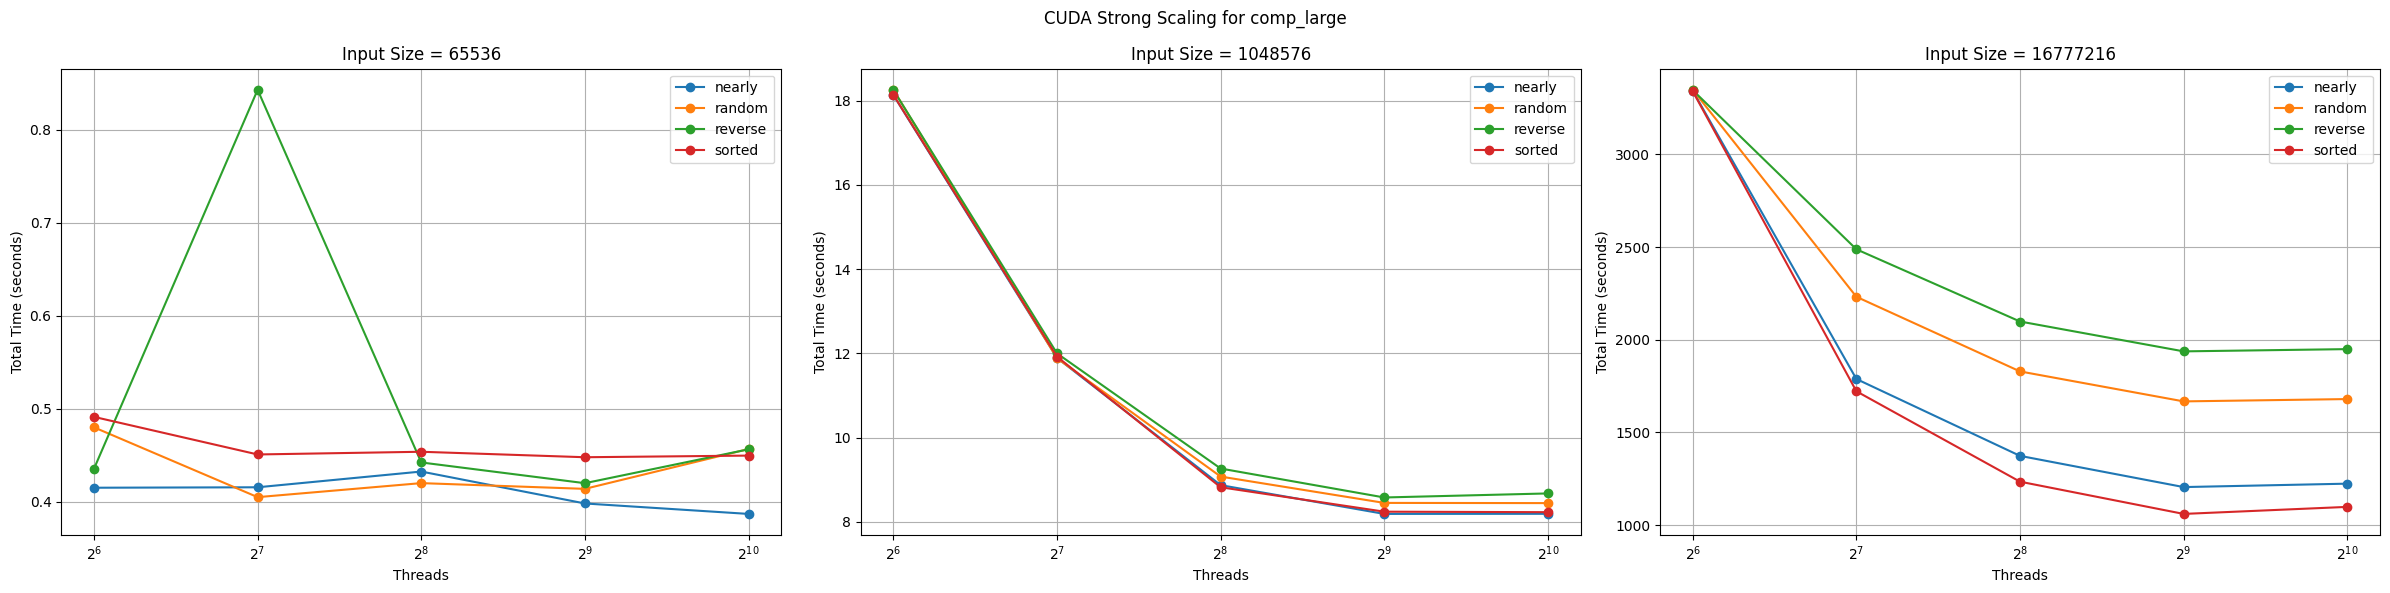

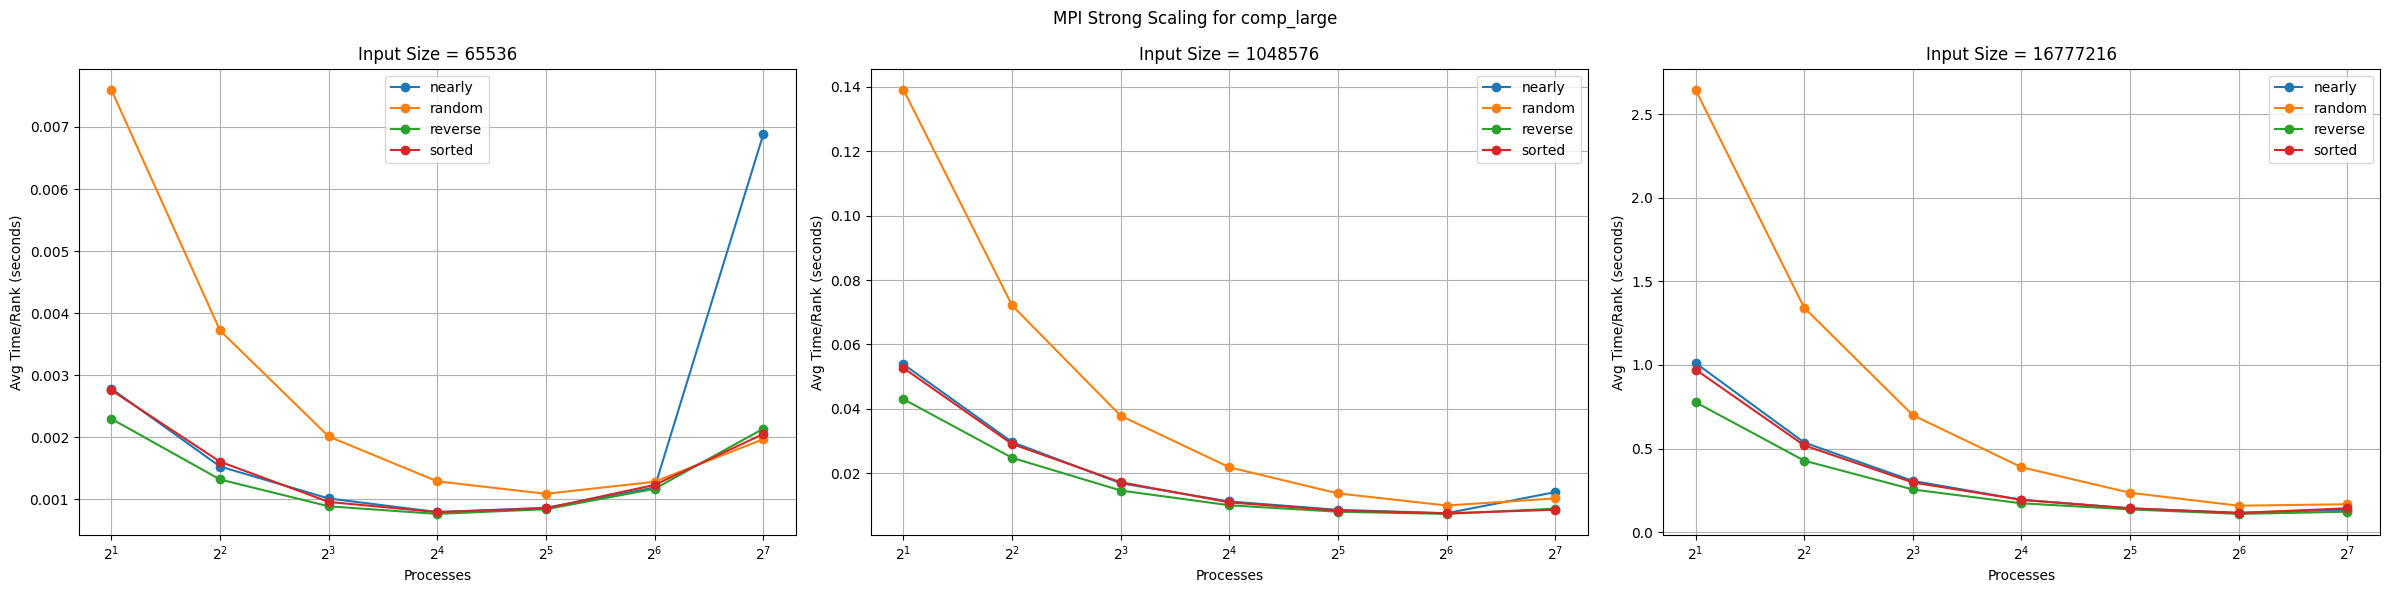

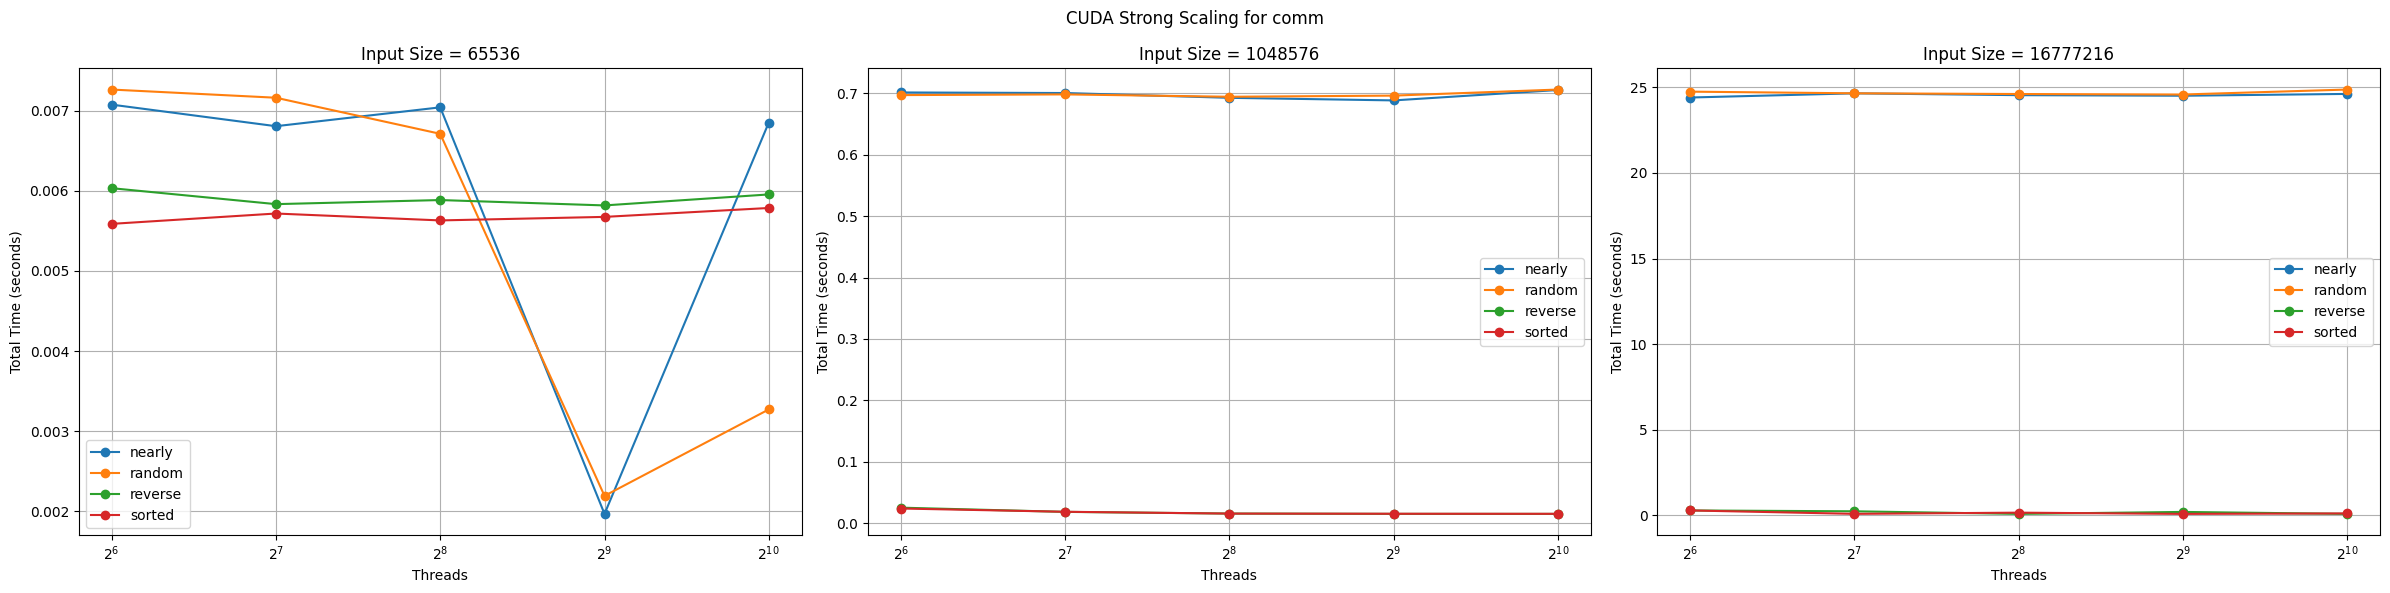

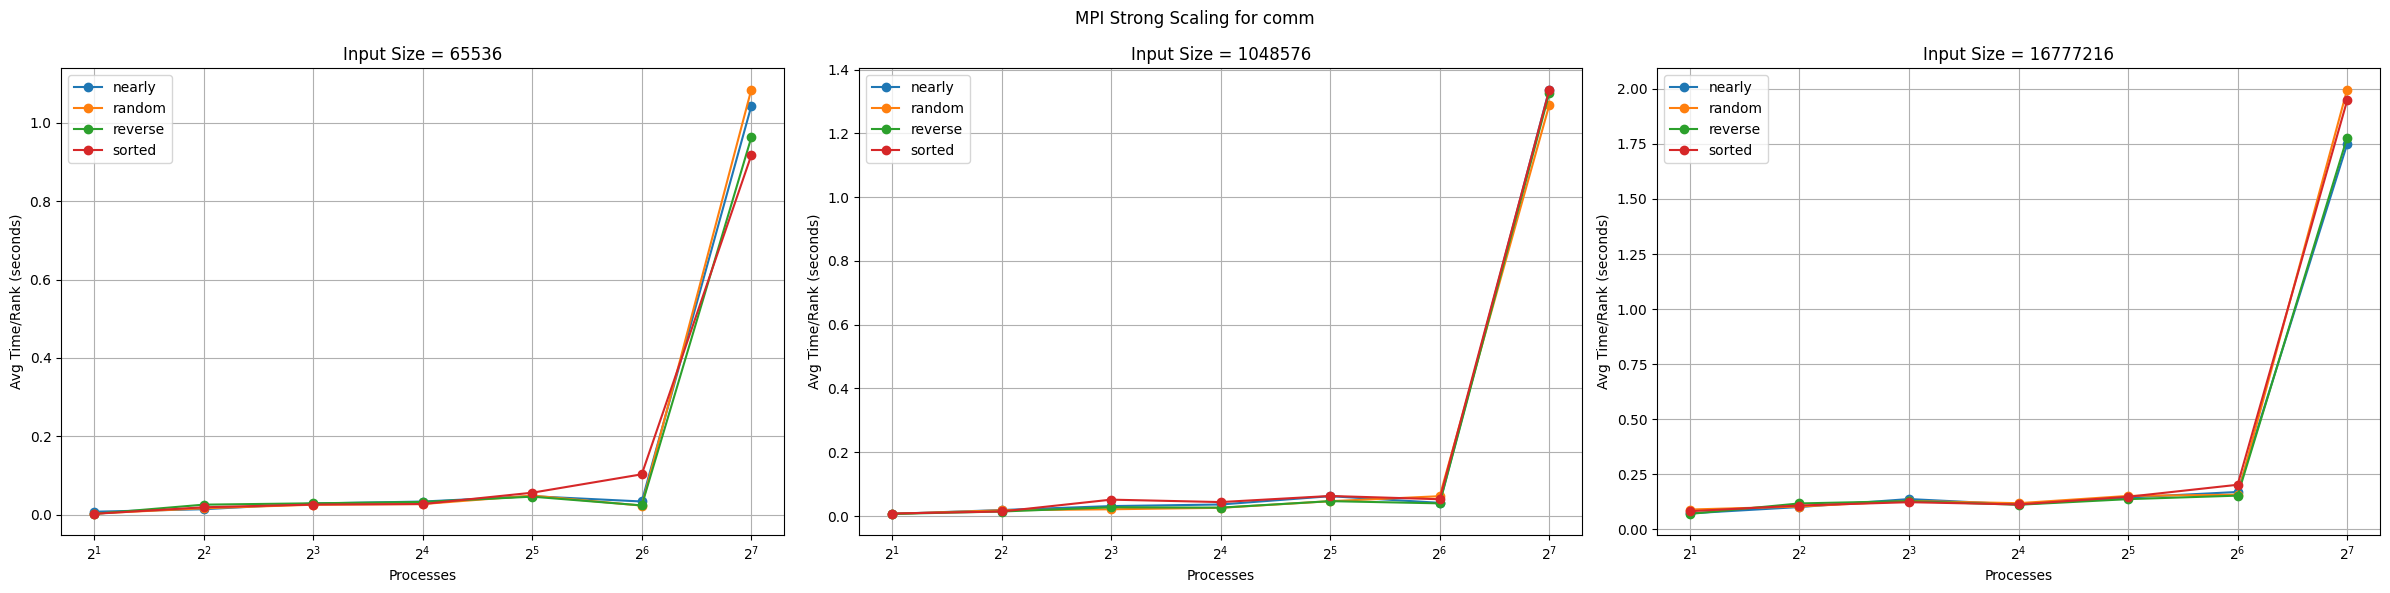

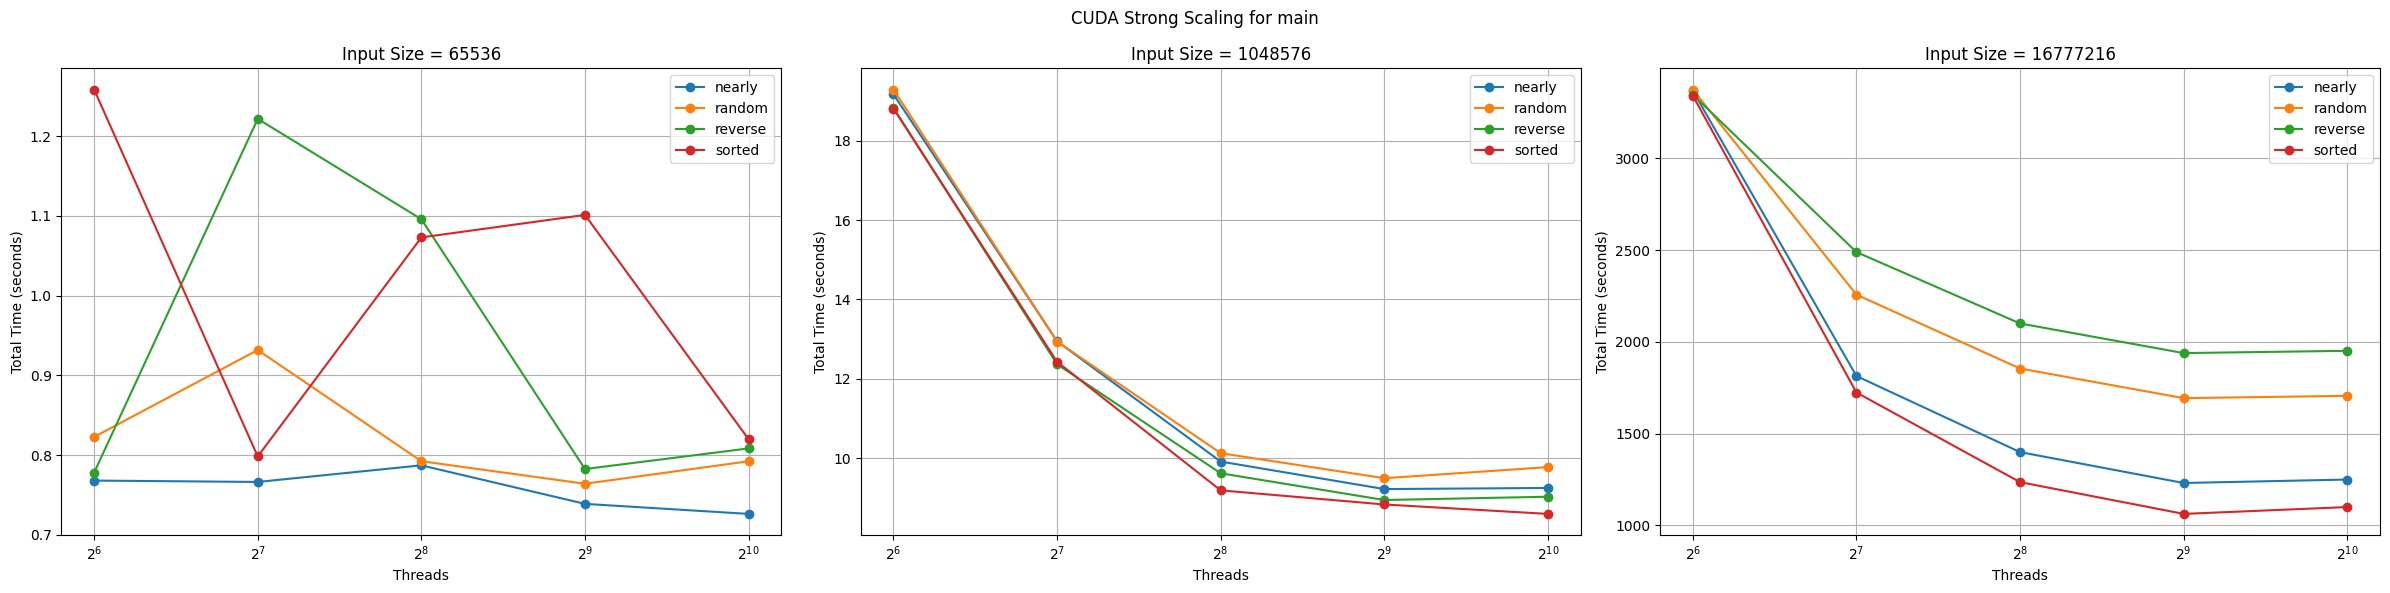

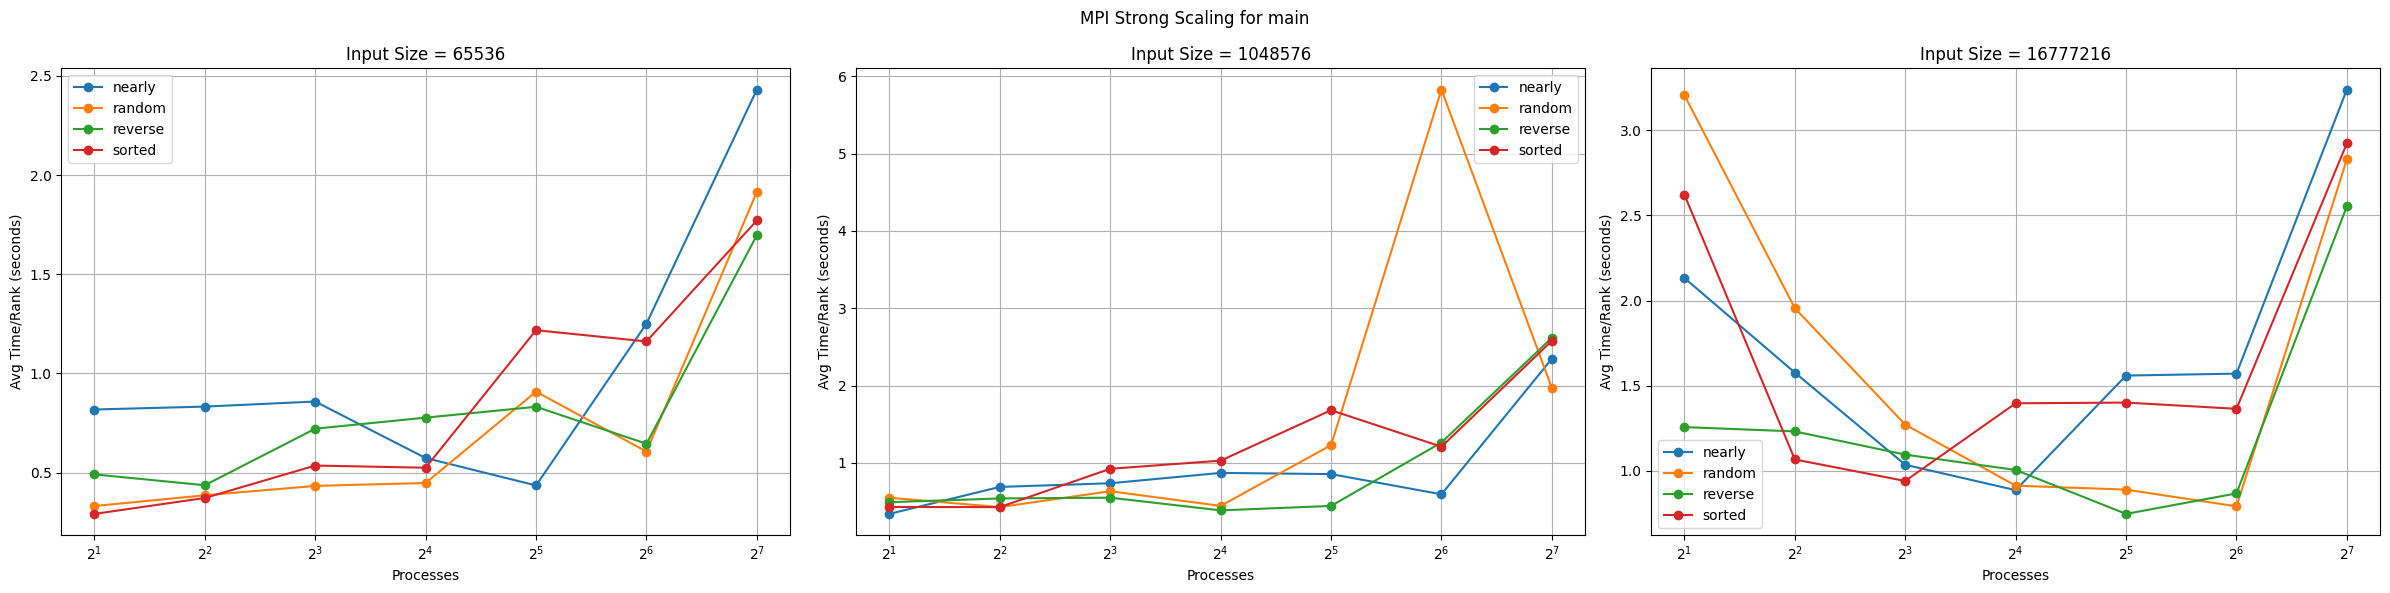

In [37]:
# strong scaling
for m in measures:
    cuda_strong = [ctk_cuda_strong_nearly.dataframe.loc[m][s].rename(columns={"Total time" : "nearly"}) \
                   .join(ctk_cuda_strong_random.dataframe.loc[m][s].rename(columns={"Total time" : "random"})) \
                   .join(ctk_cuda_strong_reverse.dataframe.loc[m][s].rename(columns={"Total time" : "reverse"})) \
                   .join(ctk_cuda_strong_sorted.dataframe.loc[m][s].rename(columns={"Total time" : "sorted"})) for s in input_sizes]
    mpi_strong = [ctk_mpi_strong_nearly.dataframe.loc[m][s].rename(columns={"Avg time/rank" : "nearly"}) \
                   .join(ctk_mpi_strong_random.dataframe.loc[m][s].rename(columns={"Avg time/rank" : "random"})) \
                   .join(ctk_mpi_strong_reverse.dataframe.loc[m][s].rename(columns={"Avg time/rank" : "reverse"})) \
                   .join(ctk_mpi_strong_sorted.dataframe.loc[m][s].rename(columns={"Avg time/rank" : "sorted"})) for s in input_sizes]

    plot_strong(cuda_strong, m)
    plot_strong(mpi_strong, m, cuda=False)

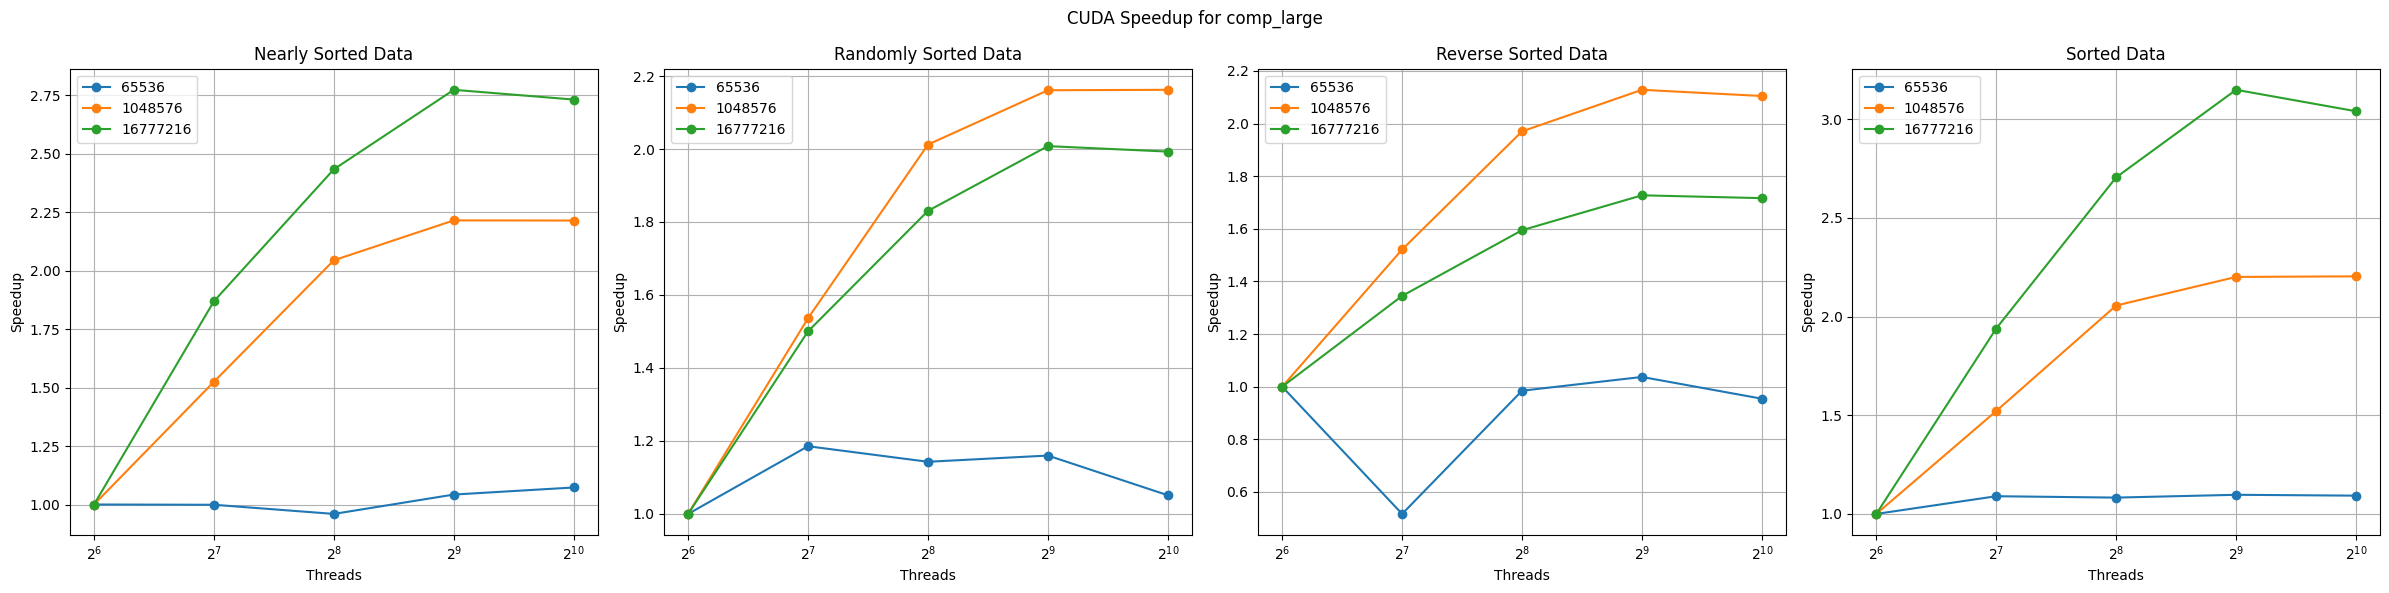

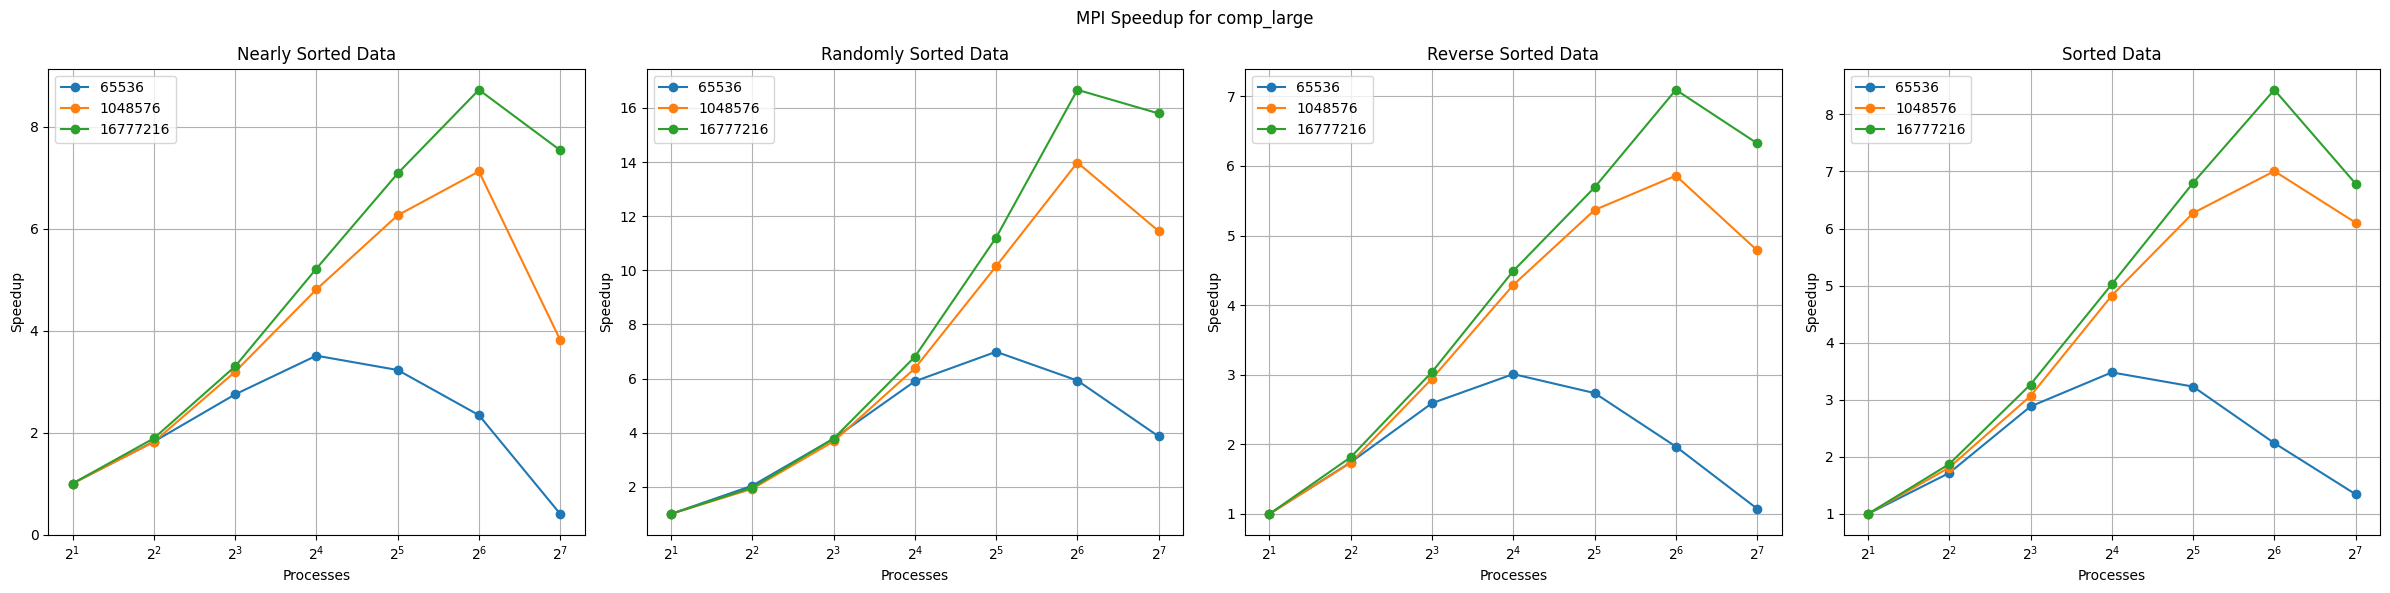

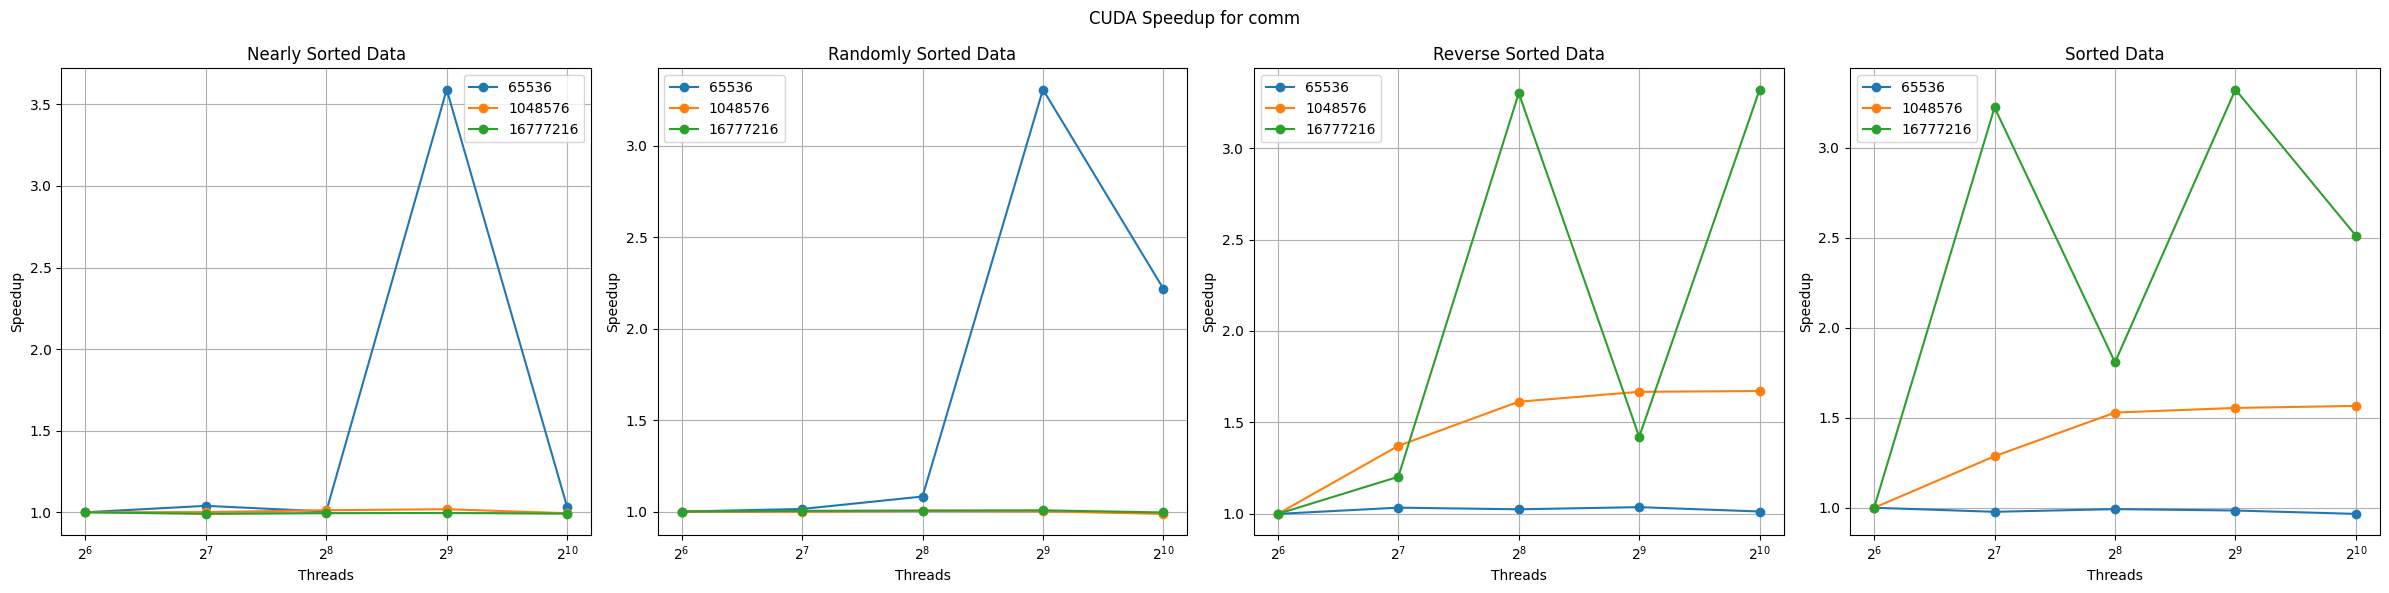

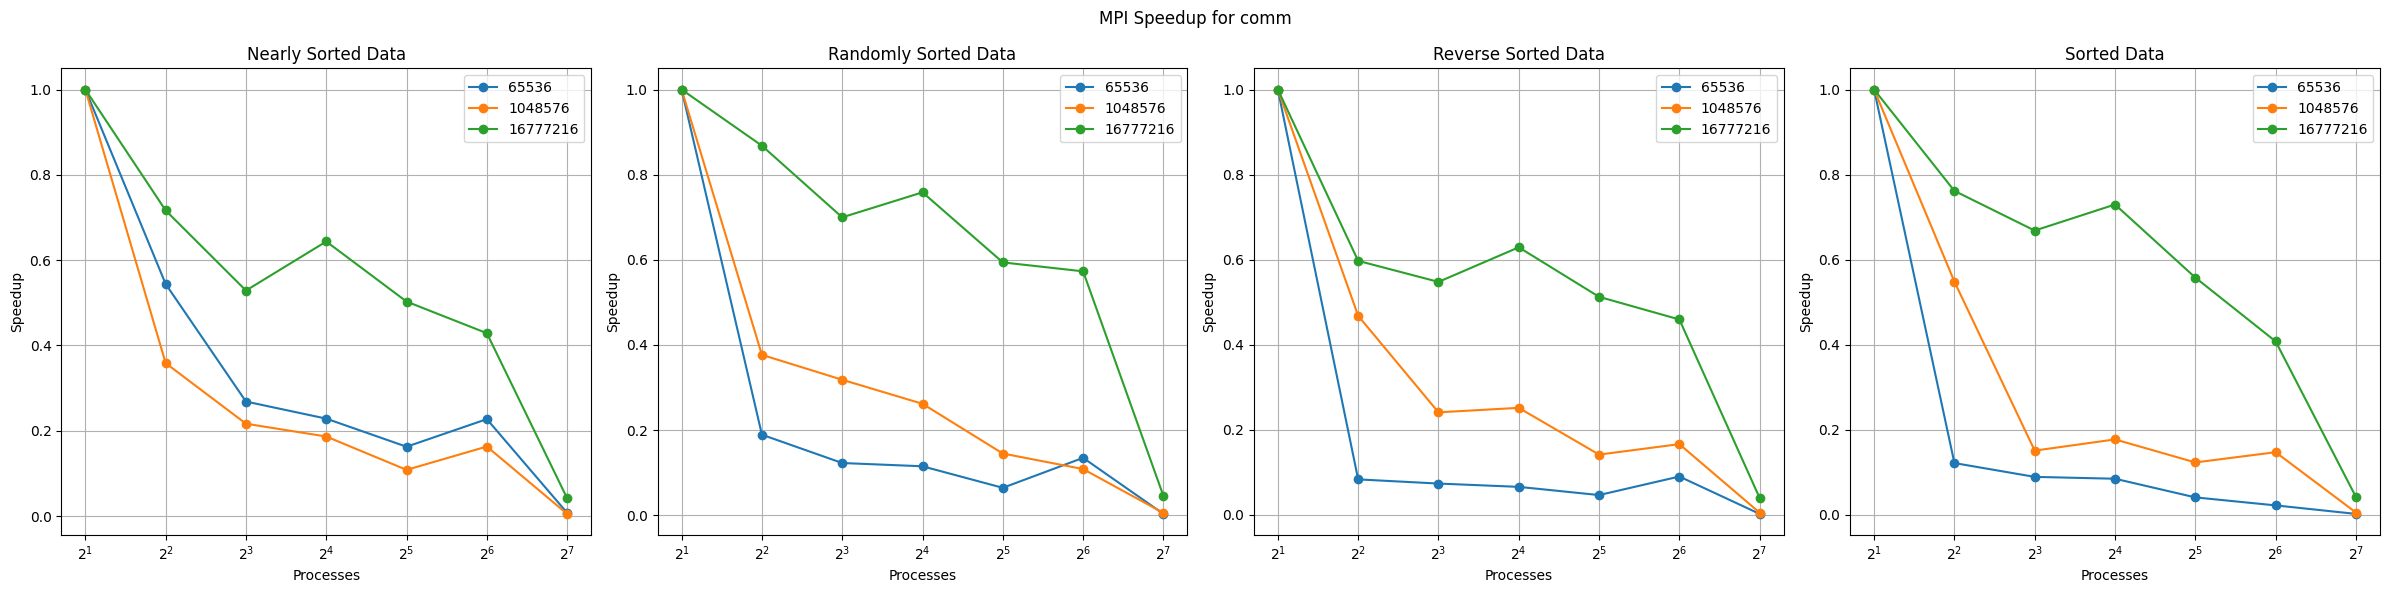

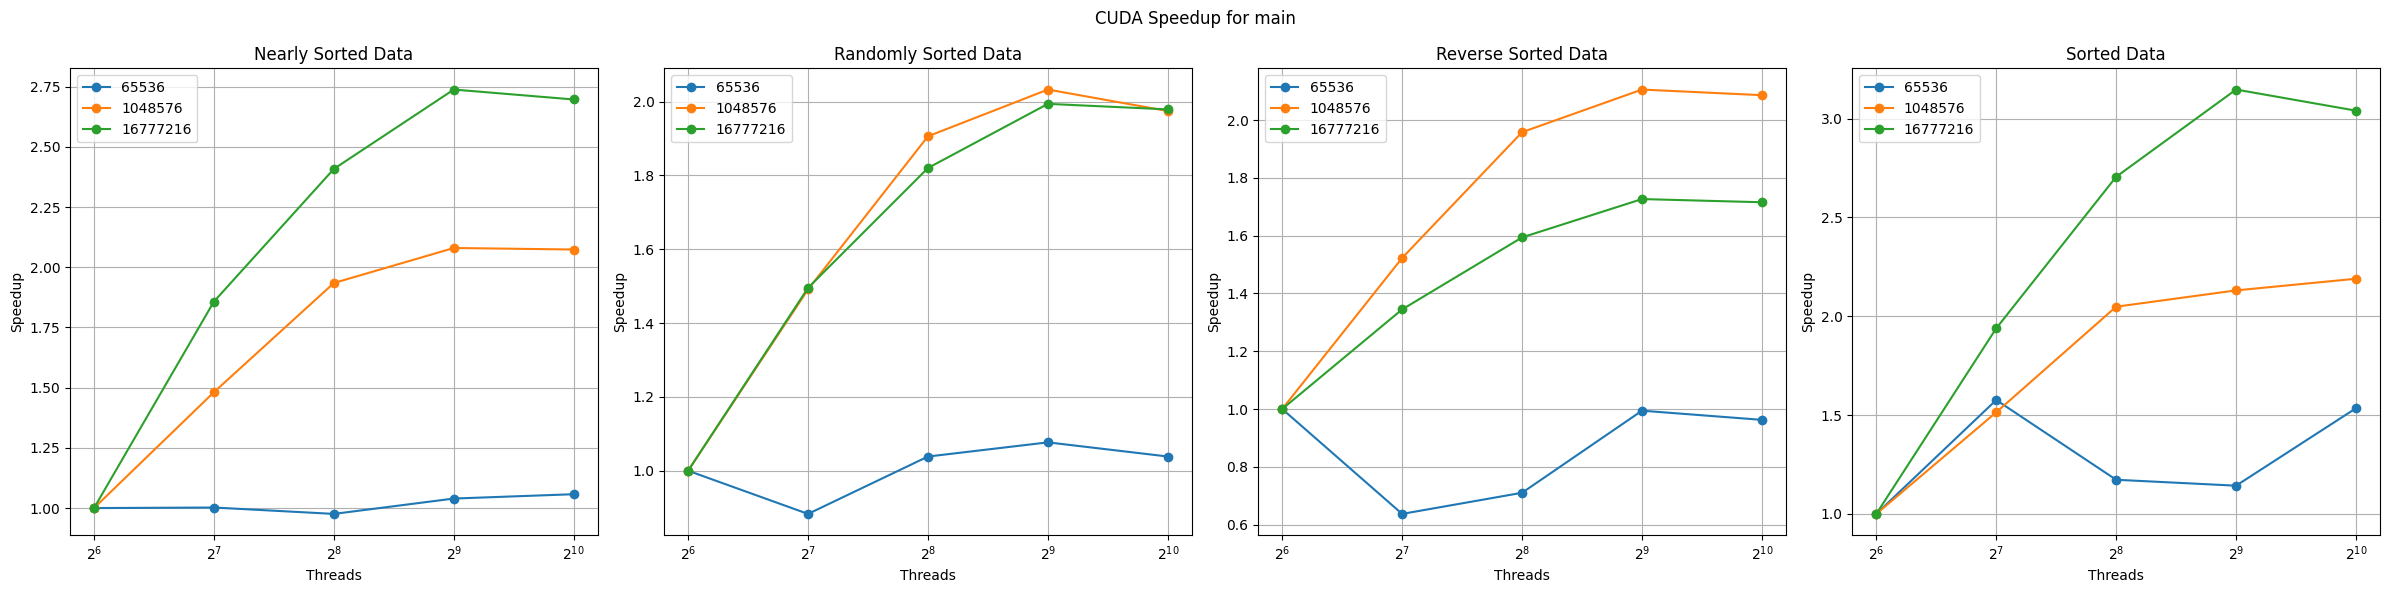

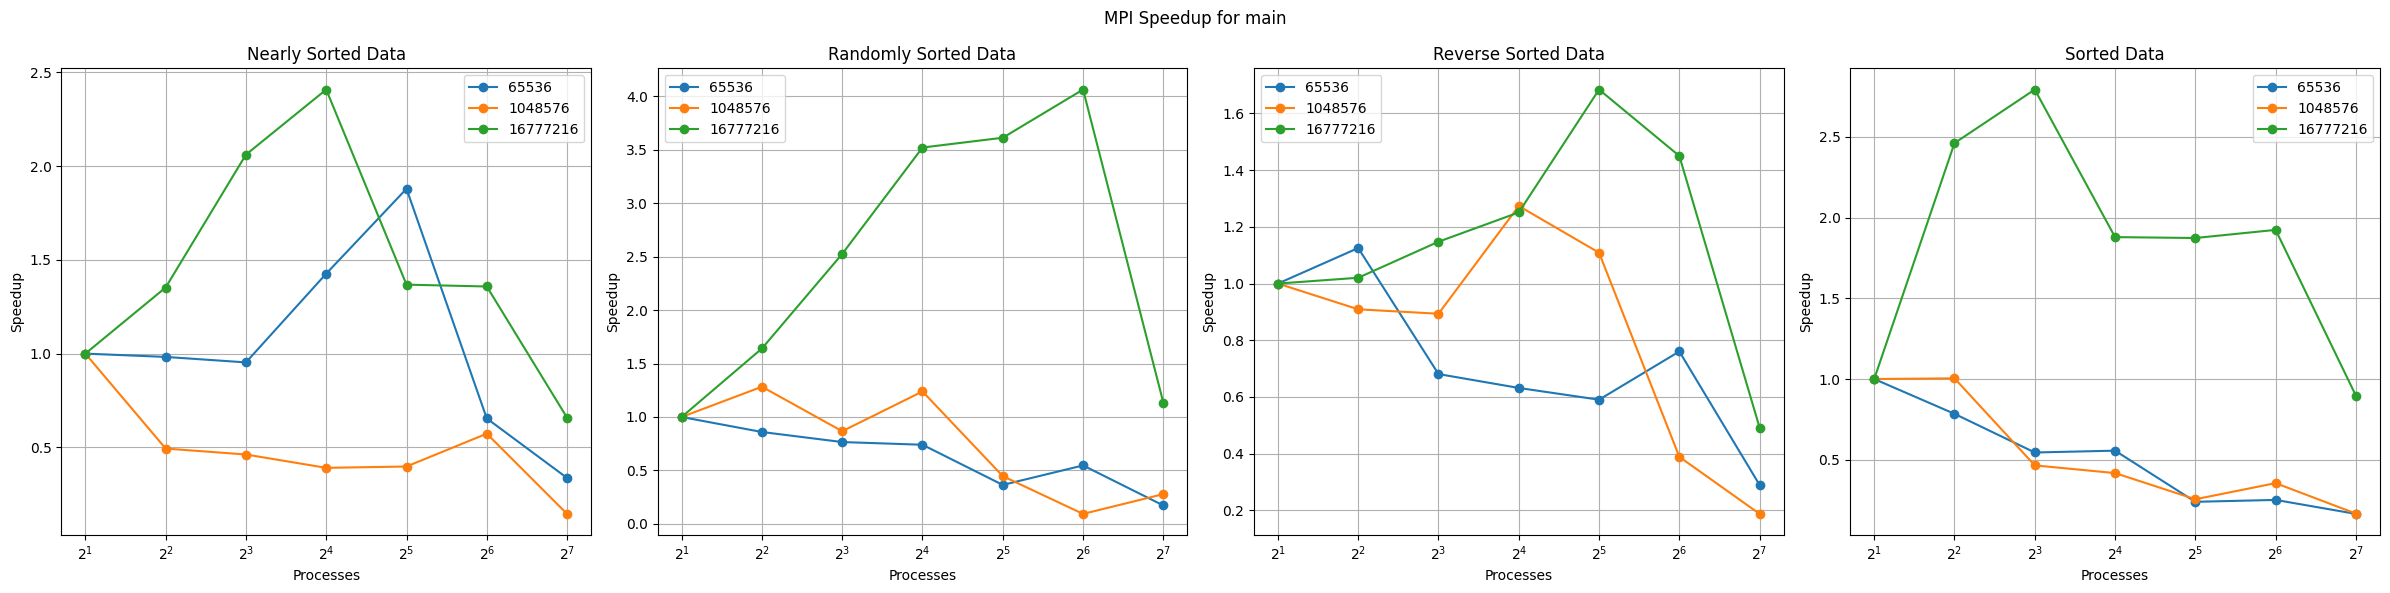

In [54]:
# speedup
for m in measures:
    speedup_cuda_nearly_comp = [[ctk_cuda_strong_nearly.dataframe[s]["Total time"][m][64] / ctk_cuda_strong_nearly.dataframe[s]["Total time"][m][t] for t in threads] for s in input_sizes]
    speedup_cuda_random_comp = [[ctk_cuda_strong_random.dataframe[s]["Total time"][m][64] / ctk_cuda_strong_random.dataframe[s]["Total time"][m][t] for t in threads] for s in input_sizes]
    speedup_cuda_reverse_comp = [[ctk_cuda_strong_reverse.dataframe[s]["Total time"][m][64] / ctk_cuda_strong_reverse.dataframe[s]["Total time"][m][t] for t in threads] for s in input_sizes]
    speedup_cuda_sorted_comp = [[ctk_cuda_strong_sorted.dataframe[s]["Total time"][m][64] / ctk_cuda_strong_sorted.dataframe[s]["Total time"][m][t] for t in threads] for s in input_sizes]
    speedup_cuda_comp = [speedup_cuda_nearly_comp, speedup_cuda_random_comp, speedup_cuda_reverse_comp, speedup_cuda_sorted_comp]

    speedup_mpi_nearly_comp = [[ctk_mpi_strong_nearly.dataframe[s]["Avg time/rank"][m][2] / ctk_mpi_strong_nearly.dataframe[s]["Avg time/rank"][m][p] for p in procs] for s in input_sizes]
    speedup_mpi_random_comp = [[ctk_mpi_strong_random.dataframe[s]["Avg time/rank"][m][2] / ctk_mpi_strong_random.dataframe[s]["Avg time/rank"][m][p] for p in procs] for s in input_sizes]
    speedup_mpi_reverse_comp = [[ctk_mpi_strong_reverse.dataframe[s]["Avg time/rank"][m][2] / ctk_mpi_strong_reverse.dataframe[s]["Avg time/rank"][m][p] for p in procs] for s in input_sizes]
    speedup_mpi_sorted_comp = [[ctk_mpi_strong_sorted.dataframe[s]["Avg time/rank"][m][2] / ctk_mpi_strong_sorted.dataframe[s]["Avg time/rank"][m][p] for p in procs] for s in input_sizes]
    speedup_mpi_comp = [speedup_mpi_nearly_comp, speedup_mpi_random_comp, speedup_mpi_reverse_comp, speedup_mpi_sorted_comp]

    plot_speedup(speedup_cuda_comp, m)
    plot_speedup(speedup_mpi_comp, m, cuda=False)

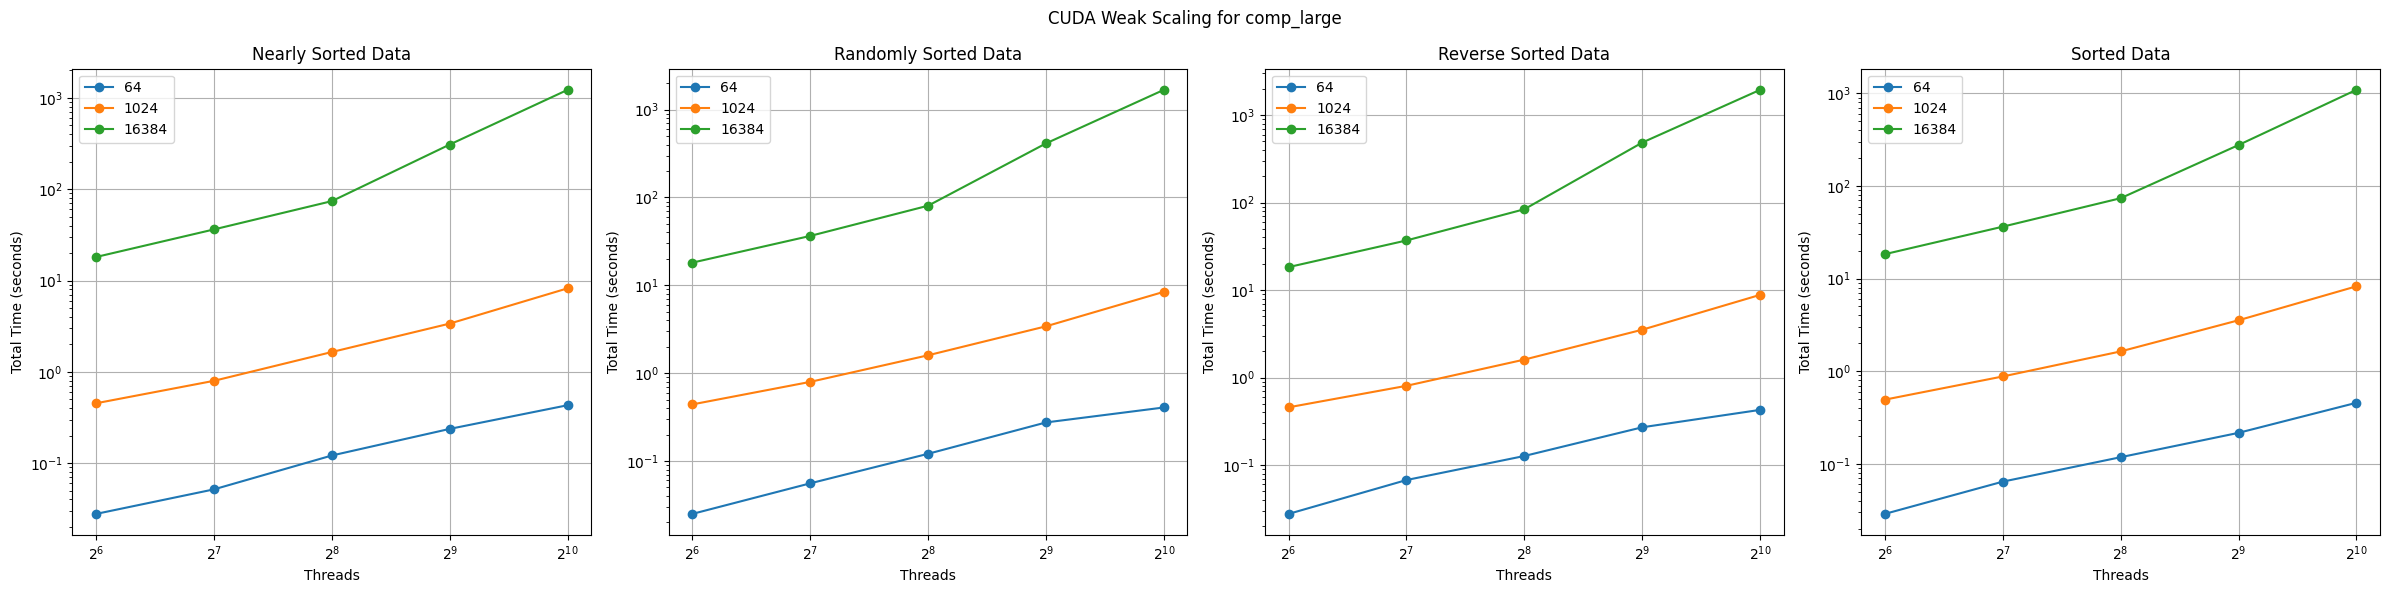

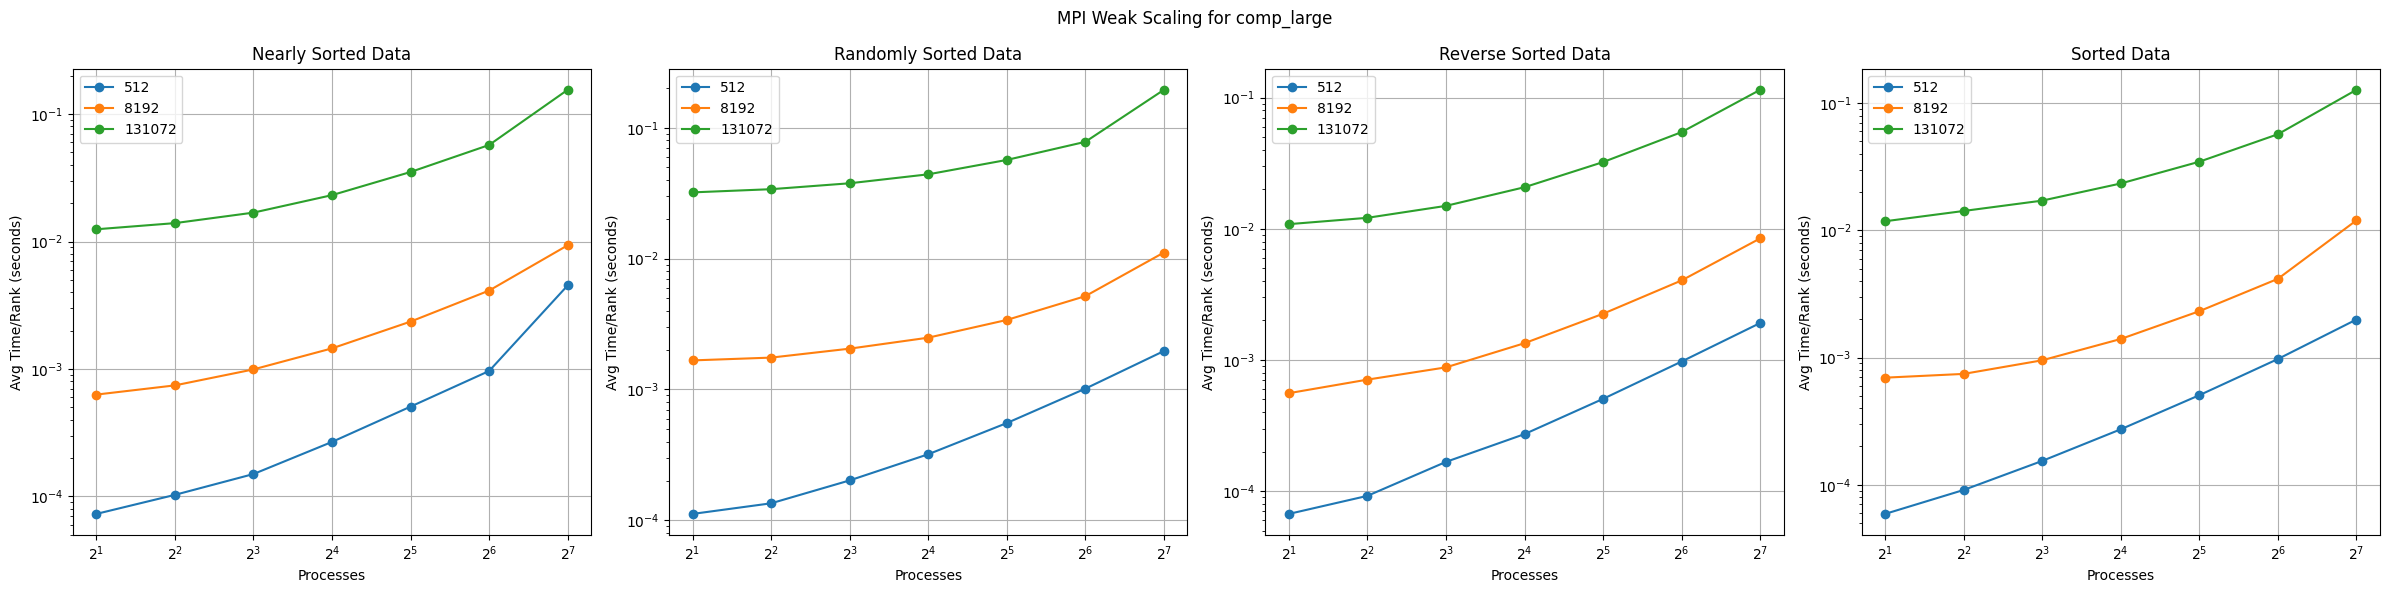

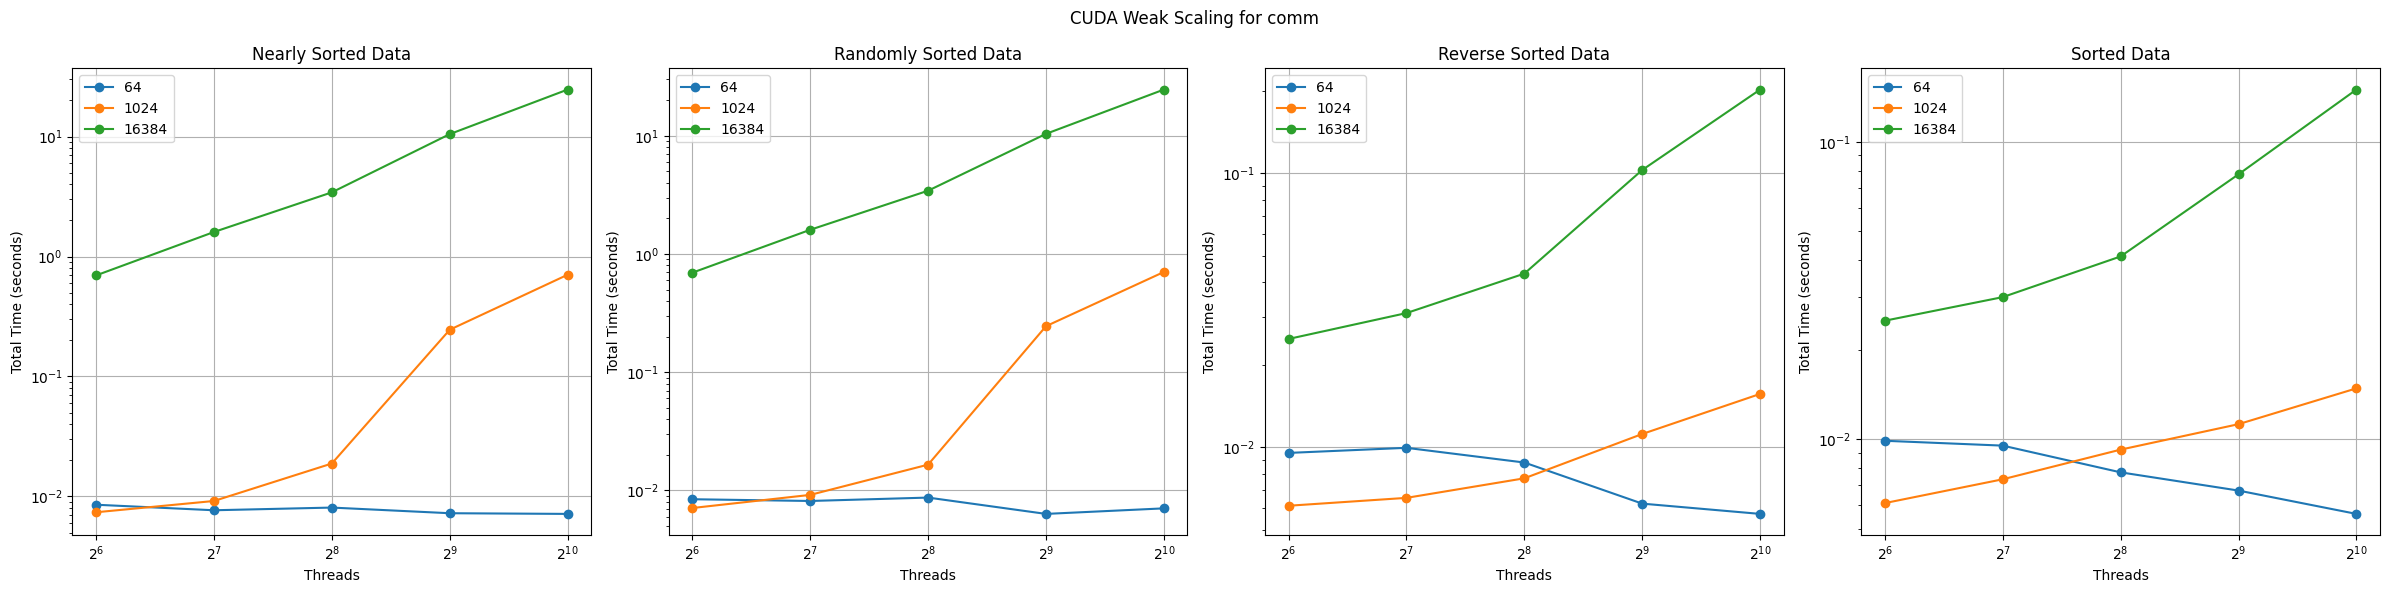

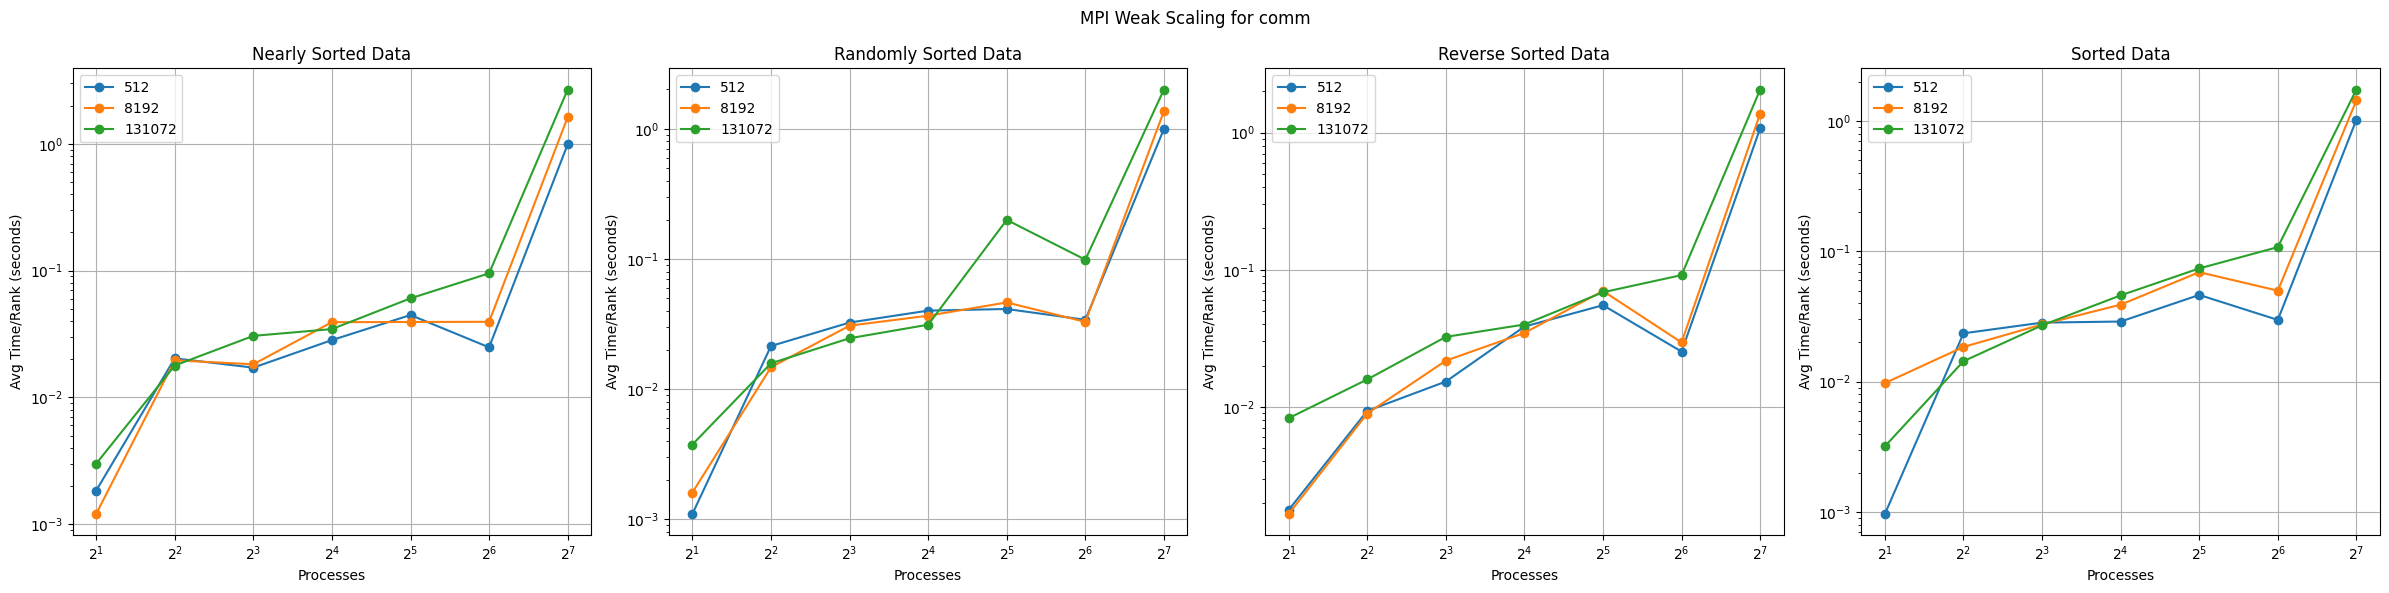

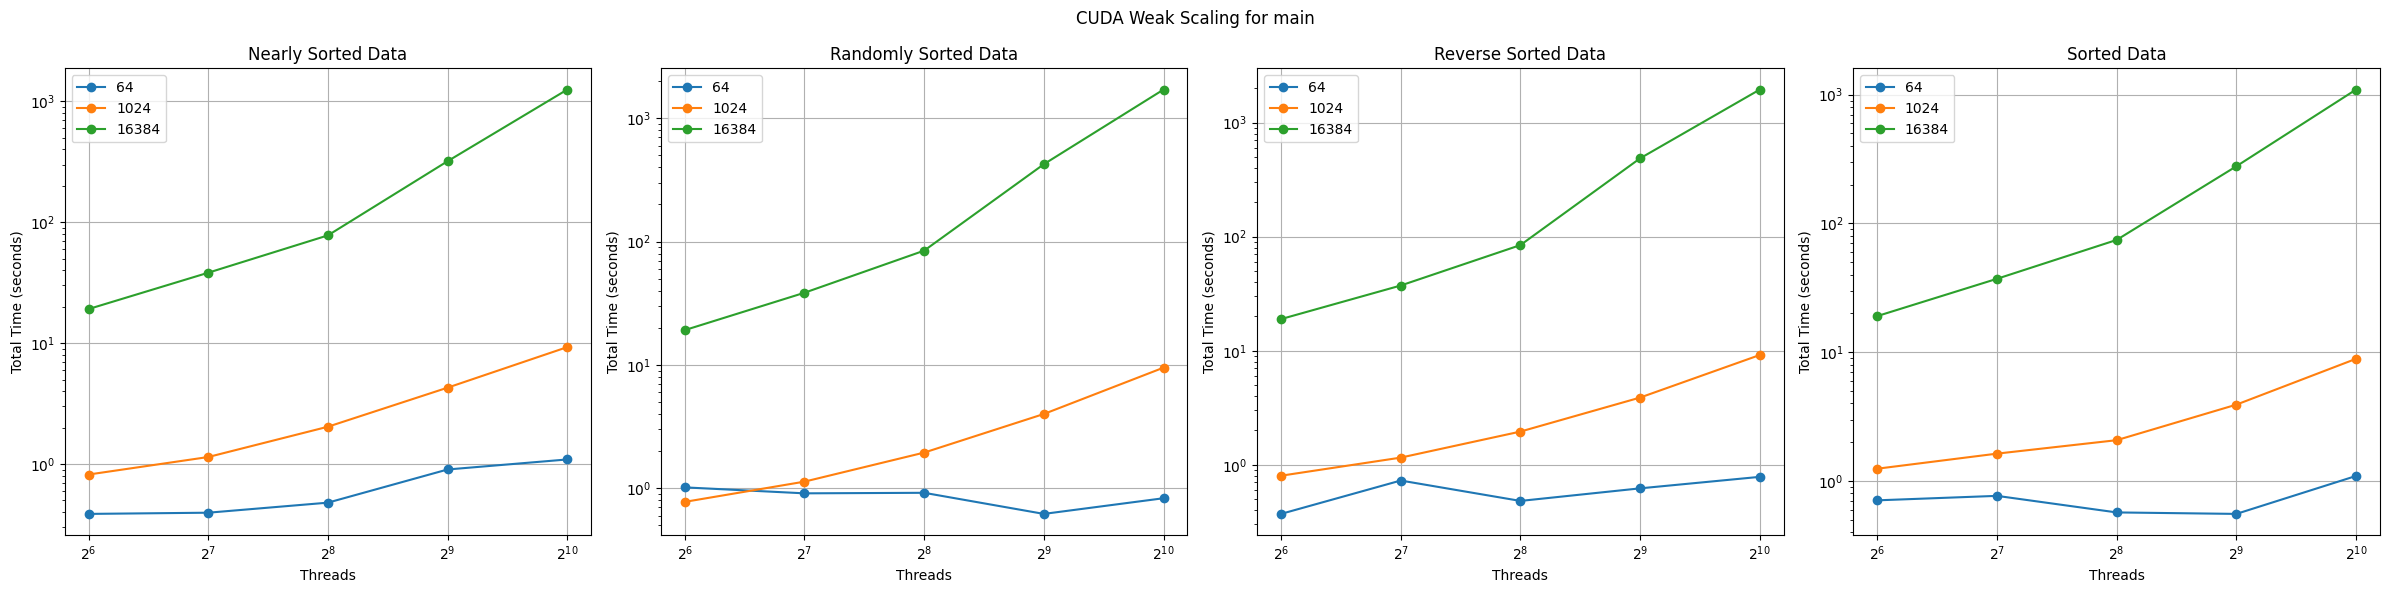

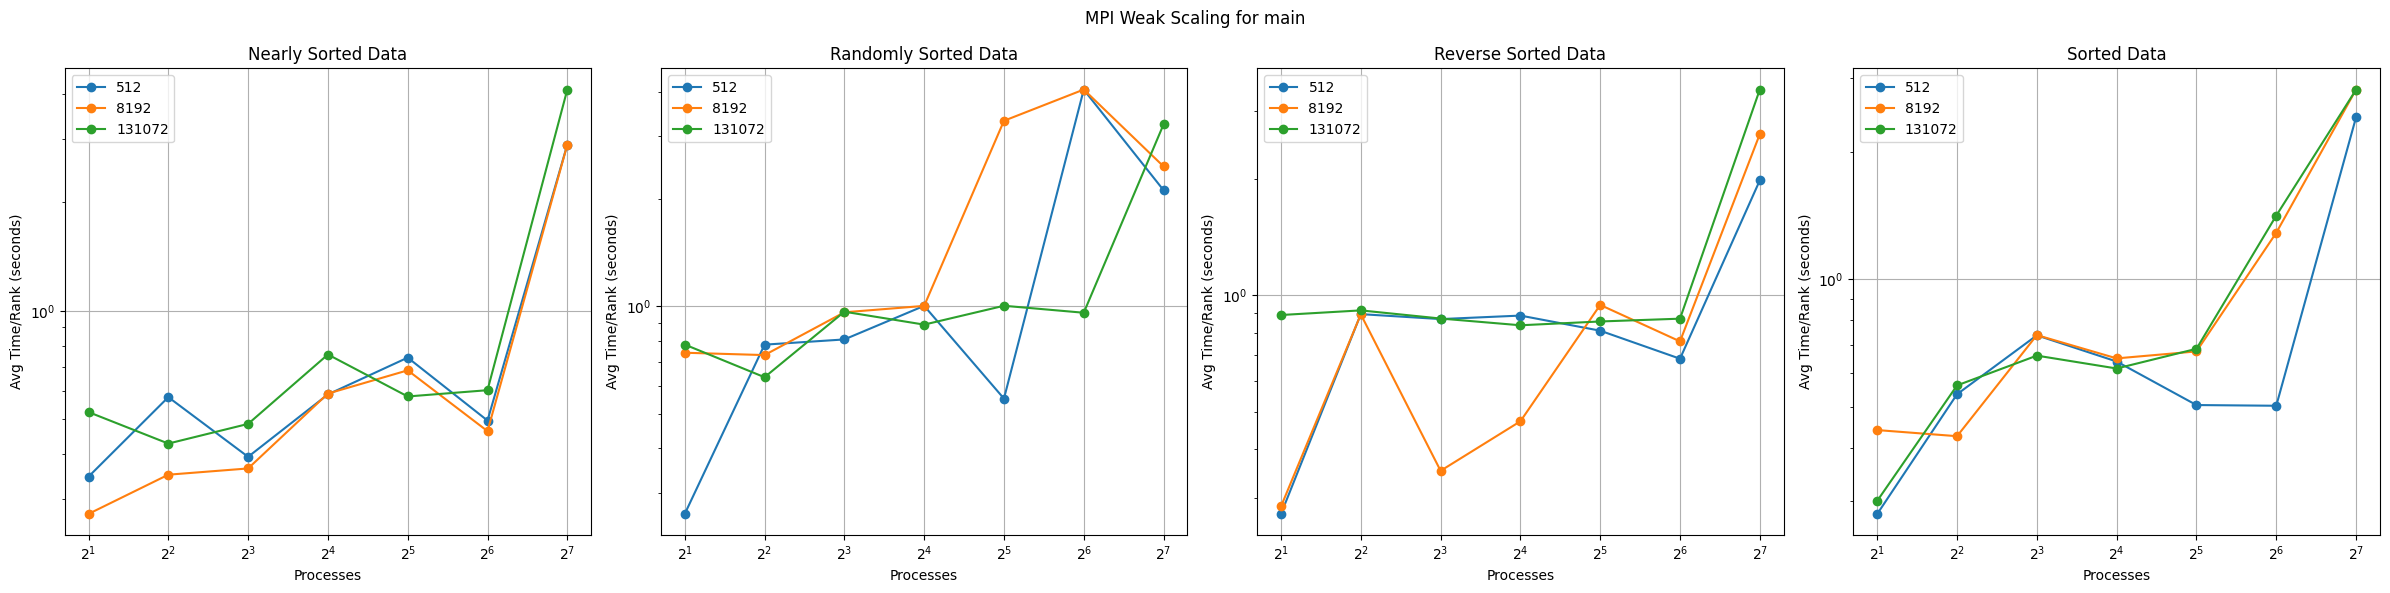

In [39]:
# weak scaling
for m in measures:
    cuda_weak = [ctk_cuda_weak_nearly.dataframe.loc[m], ctk_cuda_weak_random.dataframe.loc[m], ctk_cuda_weak_reverse.dataframe.loc[m], ctk_cuda_weak_sorted.dataframe.loc[m]]
    mpi_weak = [ctk_mpi_weak_nearly.dataframe.loc[m], ctk_mpi_weak_random.dataframe.loc[m], ctk_mpi_weak_reverse.dataframe.loc[m], ctk_mpi_weak_sorted.dataframe.loc[m]]

    plot_weak(cuda_weak, m)
    plot_weak(mpi_weak, m, cuda=False)

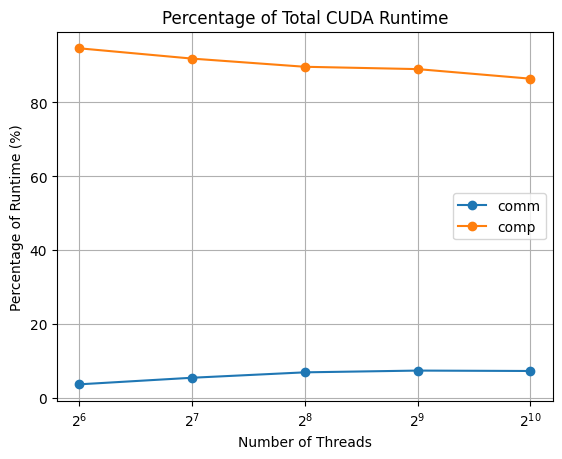

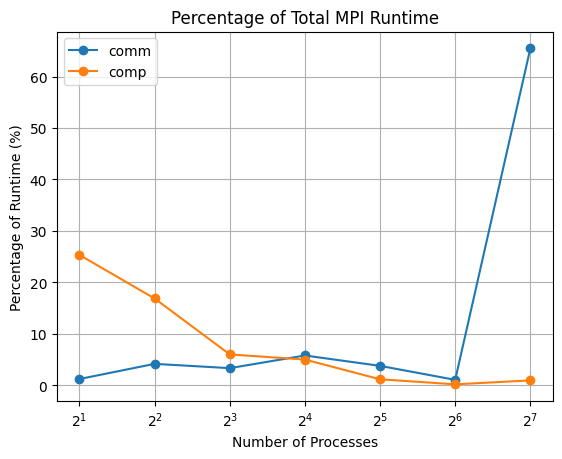

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Percentage of Total MPI Runtime'}, xlabel='Number of Processes', ylabel='Percentage of Runtime (%)'>)

In [56]:
# comparing comm and comp times
comm_per_cuda = [ctk_cuda_strong_random.dataframe[1048576]["Total time"]["comm"][t] / ctk_cuda_strong_random.dataframe[1048576]["Total time"]["main"][t] * 100 for t in threads]
comp_per_cuda = [ctk_cuda_strong_random.dataframe[1048576]["Total time"]["comp"][t] / ctk_cuda_strong_random.dataframe[1048576]["Total time"]["main"][t] * 100 for t in threads]
comm_per_mpi = [ctk_mpi_strong_random.dataframe[1048576]["Avg time/rank"]["comm"][p] / ctk_mpi_strong_random.dataframe[1048576]["Avg time/rank"]["main"][p] * 100 for p in procs]
comp_per_mpi = [ctk_mpi_strong_random.dataframe[1048576]["Avg time/rank"]["comp"][p] / ctk_mpi_strong_random.dataframe[1048576]["Avg time/rank"]["main"][p] * 100 for p in procs]

plot_comm_comp(threads, comm_per_cuda, comp_per_cuda, "Percentage of Total CUDA Runtime", "Number of Threads")
plot_comm_comp(procs, comm_per_mpi, comp_per_mpi, "Percentage of Total MPI Runtime", "Number of Processes")

In [55]:
# comparing strong scaling between algorithms
for m in measures:
    cuda_algo = [ctk_cuda_strong_random.dataframe.loc[m][s].rename(columns={"Total time" : "bubble"}) \
                   .join(ctk_cuda_strong_merge.dataframe.loc[m][s].rename(columns={"Total time" : "merge"})) \
                   .join(ctk_cuda_strong_quick.dataframe.loc[m][s].rename(columns={"Total time" : "quick"})) \
                   .join(ctk_cuda_strong_selection.dataframe.loc[m][s].rename(columns={"Total time" : "selection"})) for s in input_sizes]
    mpi_algo = [ctk_mpi_strong_random.dataframe.loc[m][s].rename(columns={"Avg time/rank" : "bubble"}) \
                   .join(ctk_mpi_strong_merge.dataframe.loc[m][s].rename(columns={"Avg time/rank" : "merge"})) \
                   .join(ctk_mpi_strong_quick.dataframe.loc[m][s].rename(columns={"Avg time/rank" : "quick"})) \
                   .join(ctk_mpi_strong_selection.dataframe.loc[m][s].rename(columns={"Avg time/rank" : "selection"})) for s in input_sizes]
    
    plot_algo_comp(cuda_algo, m)
    plot_algo_comp(mpi_algo, m, cuda=False)

NameError: name 'ctk_cuda_strong_merge' is not defined

In [ ]:
# comparing weak scaling between algorithms
for m in measures:
    cuda_algo = [ctk_cuda_weak_random.dataframe.loc[m][s].rename(columns={"Total time" : "bubble"}) \
                   .join(ctk_cuda_weak_merge.dataframe.loc[m][s].rename(columns={"Total time" : "merge"})) \
                   .join(ctk_cuda_weak_quick.dataframe.loc[m][s].rename(columns={"Total time" : "quick"})) \
                   .join(ctk_cuda_weak_selection.dataframe.loc[m][s].rename(columns={"Total time" : "selection"})) for s in thread_size]
    mpi_algo = [ctk_mpi_weak_random.dataframe.loc[m][s].rename(columns={"Avg time/rank" : "bubble"}) \
                   .join(ctk_mpi_weak_merge.dataframe.loc[m][s].rename(columns={"Avg time/rank" : "merge"})) \
                   .join(ctk_mpi_weak_quick.dataframe.loc[m][s].rename(columns={"Avg time/rank" : "quick"})) \
                   .join(ctk_mpi_weak_selection.dataframe.loc[m][s].rename(columns={"Avg time/rank" : "selection"})) for s in rank_size]
    
    plot_algo_comp(cuda_algo, m, strong=False)
    plot_algo_comp(mpi_algo, m, cuda=False, strong=False)